# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [9]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/inputR5KrjnANiKVhLWAkpXhNBe'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper
import zipfile

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)
#celeba_path = os.path.join(data_dir, 'celeba.zip')

#with zipfile.ZipFile(celeba_path) as zf:
#    zf.extractall(celeba_path)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

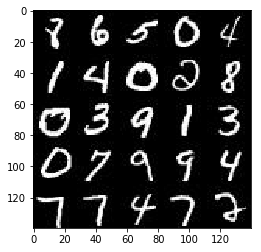

In [10]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

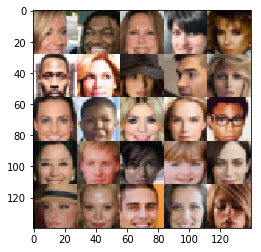

In [11]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf
import keras

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
    
K = keras.backend.backend()
if K =='tensorflow':
    keras.backend.set_image_dim_ordering('th')


TensorFlow Version: 1.5.0


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: No GPU found. Please use a GPU to train your neural network.
  from ipykernel import kernelapp as app


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [33]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [14]:
def lrelu(x, alpha):
    return tf.maximum(x *alpha, x)

def discriminator(images, reuse=False, alpha=0.2, keep_prob=0.8):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        x1 = tf.nn.dropout(x1, keep_prob=keep_prob)
        relu1 = lrelu(x1, alpha)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        x2 = tf.nn.dropout(x2, keep_prob=keep_prob)
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = lrelu(bn2, alpha)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        x3 = tf.nn.dropout(x3, keep_prob=keep_prob)
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = lrelu(bn3, alpha)
        # 4x4x256
        
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat,1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [34]:
def generator(z, out_channel_dim, is_train=True, alpha=0.1):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse=(not is_train)):
        x1 = tf.layers.dense(z, 2*2*512)
        x1 = tf.reshape(x1, (-1, 2, 2, 512)) #Reshape it to start the convolutional stack
        x1 = lrelu(x1, alpha)
        # 2x2x512
        
        x2= tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = lrelu(x2, alpha)
        # 7x7x256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = lrelu(x3, alpha)
        # 14x14x128
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        #28x28x3
        
        out = tf.tanh(logits)
    
    return out
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [38]:
import numpy as np

def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True, alpha=alpha)
    d_fake_out, d_fake_logits = discriminator(g_model, alpha=alpha)
    d_real_out, d_real_logits = discriminator(input_real, reuse=True, alpha=alpha)
    
    real_labels = tf.ones_like(d_real_out)*(np.random.uniform(0.7, 1.2))
    fake_labels = tf.zeros_like(d_fake_out)
    g_labels = tf.ones_like(d_fake_out)
    
    d_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=fake_labels))
    d_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_real_logits, labels=real_labels))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=g_labels))
    
    d_loss = d_fake_loss+d_real_loss
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [39]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [40]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [43]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    
    input_real, input_z, learn_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2.0 # Rescaling images
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate:learning_rate})
        
                
                if steps%10 == 0:
                    d_train_loss = d_loss.eval({input_real:batch_images, input_z: batch_z})
                    g_train_loss = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{} Batch# {}...".format(epoch_i+1, epoch_count, steps),
                          "Discriminator Loss: {:.4f}...".format(d_train_loss),
                          "Generator Loss: {:.4f}".format(g_train_loss))
                
                if steps%100 == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2 Batch# 10... Discriminator Loss: 0.5614... Generator Loss: 1.0920
Epoch 1/2 Batch# 20... Discriminator Loss: -0.0175... Generator Loss: 2.5225
Epoch 1/2 Batch# 30... Discriminator Loss: 0.1012... Generator Loss: 2.0864
Epoch 1/2 Batch# 40... Discriminator Loss: 0.0626... Generator Loss: 2.6761
Epoch 1/2 Batch# 50... Discriminator Loss: 0.0232... Generator Loss: 5.4461
Epoch 1/2 Batch# 60... Discriminator Loss: 0.2292... Generator Loss: 4.3592
Epoch 1/2 Batch# 70... Discriminator Loss: 0.7587... Generator Loss: 1.5755
Epoch 1/2 Batch# 80... Discriminator Loss: 0.1329... Generator Loss: 3.5039
Epoch 1/2 Batch# 90... Discriminator Loss: 0.5116... Generator Loss: 1.9342
Epoch 1/2 Batch# 100... Discriminator Loss: -0.0108... Generator Loss: 2.0995


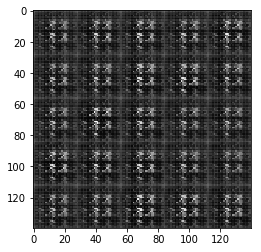

Epoch 1/2 Batch# 110... Discriminator Loss: -0.1675... Generator Loss: 3.1256
Epoch 1/2 Batch# 120... Discriminator Loss: 3.5774... Generator Loss: 1.1635
Epoch 1/2 Batch# 130... Discriminator Loss: 0.1815... Generator Loss: 4.5274
Epoch 1/2 Batch# 140... Discriminator Loss: 0.8251... Generator Loss: 1.9977
Epoch 1/2 Batch# 150... Discriminator Loss: 0.2127... Generator Loss: 3.1925
Epoch 1/2 Batch# 160... Discriminator Loss: -0.3137... Generator Loss: 4.7208
Epoch 1/2 Batch# 170... Discriminator Loss: -0.2445... Generator Loss: 3.5239
Epoch 1/2 Batch# 180... Discriminator Loss: 0.0590... Generator Loss: 2.3806
Epoch 1/2 Batch# 190... Discriminator Loss: -0.0517... Generator Loss: 4.5384
Epoch 1/2 Batch# 200... Discriminator Loss: 0.1051... Generator Loss: 1.9456


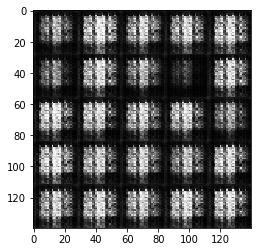

Epoch 1/2 Batch# 210... Discriminator Loss: 0.1877... Generator Loss: 2.7541
Epoch 1/2 Batch# 220... Discriminator Loss: 0.0163... Generator Loss: 6.1350
Epoch 1/2 Batch# 230... Discriminator Loss: -0.2382... Generator Loss: 3.5408
Epoch 1/2 Batch# 240... Discriminator Loss: -0.0128... Generator Loss: 4.3453
Epoch 1/2 Batch# 250... Discriminator Loss: 0.0441... Generator Loss: 3.7992
Epoch 1/2 Batch# 260... Discriminator Loss: 0.1734... Generator Loss: 1.6424
Epoch 1/2 Batch# 270... Discriminator Loss: -0.0754... Generator Loss: 5.2260
Epoch 1/2 Batch# 280... Discriminator Loss: -0.2468... Generator Loss: 3.9631
Epoch 1/2 Batch# 290... Discriminator Loss: -0.2312... Generator Loss: 3.5108
Epoch 1/2 Batch# 300... Discriminator Loss: -0.1650... Generator Loss: 8.2253


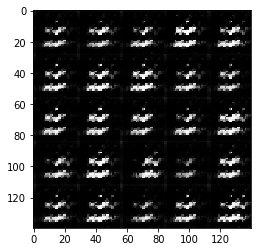

Epoch 1/2 Batch# 310... Discriminator Loss: 0.0372... Generator Loss: 3.2587
Epoch 1/2 Batch# 320... Discriminator Loss: 0.0710... Generator Loss: 3.7383
Epoch 1/2 Batch# 330... Discriminator Loss: -0.1204... Generator Loss: 4.3363
Epoch 1/2 Batch# 340... Discriminator Loss: -0.1443... Generator Loss: 3.7777
Epoch 1/2 Batch# 350... Discriminator Loss: -0.1824... Generator Loss: 8.4818
Epoch 1/2 Batch# 360... Discriminator Loss: -0.3644... Generator Loss: 4.3716
Epoch 1/2 Batch# 370... Discriminator Loss: 0.5155... Generator Loss: 3.3112
Epoch 1/2 Batch# 380... Discriminator Loss: -0.1595... Generator Loss: 5.3591
Epoch 1/2 Batch# 390... Discriminator Loss: -0.2476... Generator Loss: 4.5989
Epoch 1/2 Batch# 400... Discriminator Loss: -0.1059... Generator Loss: 3.3558


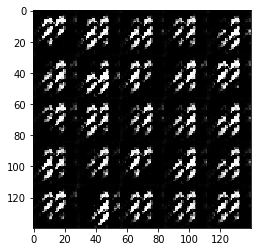

Epoch 1/2 Batch# 410... Discriminator Loss: -0.3405... Generator Loss: 3.8651
Epoch 1/2 Batch# 420... Discriminator Loss: -0.1715... Generator Loss: 4.1279
Epoch 1/2 Batch# 430... Discriminator Loss: -0.0289... Generator Loss: 3.1938
Epoch 1/2 Batch# 440... Discriminator Loss: -0.3085... Generator Loss: 6.2646
Epoch 1/2 Batch# 450... Discriminator Loss: 0.0048... Generator Loss: 3.1886
Epoch 1/2 Batch# 460... Discriminator Loss: -0.2649... Generator Loss: 3.6505
Epoch 1/2 Batch# 470... Discriminator Loss: -0.2003... Generator Loss: 4.7787
Epoch 1/2 Batch# 480... Discriminator Loss: -0.1813... Generator Loss: 5.3991
Epoch 1/2 Batch# 490... Discriminator Loss: 0.1349... Generator Loss: 3.9033
Epoch 1/2 Batch# 500... Discriminator Loss: -0.1878... Generator Loss: 4.6453


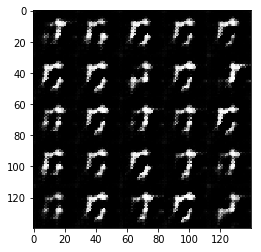

Epoch 1/2 Batch# 510... Discriminator Loss: -0.3159... Generator Loss: 5.9862
Epoch 1/2 Batch# 520... Discriminator Loss: 0.2194... Generator Loss: 3.7682
Epoch 1/2 Batch# 530... Discriminator Loss: -0.2033... Generator Loss: 5.6379
Epoch 1/2 Batch# 540... Discriminator Loss: -0.1025... Generator Loss: 5.7618
Epoch 1/2 Batch# 550... Discriminator Loss: -0.1565... Generator Loss: 6.1050
Epoch 1/2 Batch# 560... Discriminator Loss: -0.3156... Generator Loss: 4.6201
Epoch 1/2 Batch# 570... Discriminator Loss: -0.3886... Generator Loss: 7.7959
Epoch 1/2 Batch# 580... Discriminator Loss: -0.0826... Generator Loss: 3.8277
Epoch 1/2 Batch# 590... Discriminator Loss: -0.1256... Generator Loss: 5.5629
Epoch 1/2 Batch# 600... Discriminator Loss: -0.3486... Generator Loss: 7.8951


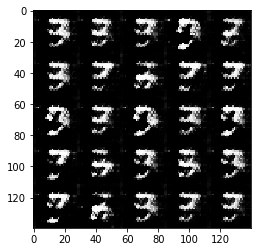

Epoch 1/2 Batch# 610... Discriminator Loss: -0.3600... Generator Loss: 5.8147
Epoch 1/2 Batch# 620... Discriminator Loss: -0.2441... Generator Loss: 5.1285
Epoch 1/2 Batch# 630... Discriminator Loss: -0.6552... Generator Loss: 7.2600
Epoch 1/2 Batch# 640... Discriminator Loss: 0.3430... Generator Loss: 3.9814
Epoch 1/2 Batch# 650... Discriminator Loss: -0.0846... Generator Loss: 6.0748
Epoch 1/2 Batch# 660... Discriminator Loss: -0.1874... Generator Loss: 7.4152
Epoch 1/2 Batch# 670... Discriminator Loss: -0.0883... Generator Loss: 4.8805
Epoch 1/2 Batch# 680... Discriminator Loss: -0.1225... Generator Loss: 5.0572
Epoch 1/2 Batch# 690... Discriminator Loss: -0.1934... Generator Loss: 3.9372
Epoch 1/2 Batch# 700... Discriminator Loss: -0.2023... Generator Loss: 5.0492


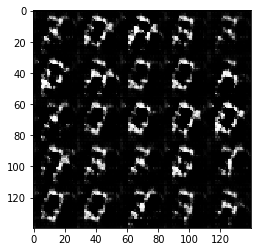

Epoch 1/2 Batch# 710... Discriminator Loss: -0.0715... Generator Loss: 4.1945
Epoch 1/2 Batch# 720... Discriminator Loss: -0.2685... Generator Loss: 6.8438
Epoch 1/2 Batch# 730... Discriminator Loss: 0.5782... Generator Loss: 3.0586
Epoch 1/2 Batch# 740... Discriminator Loss: 0.0654... Generator Loss: 3.7650
Epoch 1/2 Batch# 750... Discriminator Loss: -0.0394... Generator Loss: 5.2280
Epoch 1/2 Batch# 760... Discriminator Loss: 0.1019... Generator Loss: 3.3573
Epoch 1/2 Batch# 770... Discriminator Loss: -0.0768... Generator Loss: 5.0593
Epoch 1/2 Batch# 780... Discriminator Loss: -0.1216... Generator Loss: 4.0297
Epoch 1/2 Batch# 790... Discriminator Loss: 0.1416... Generator Loss: 4.0985
Epoch 1/2 Batch# 800... Discriminator Loss: -0.3510... Generator Loss: 6.0504


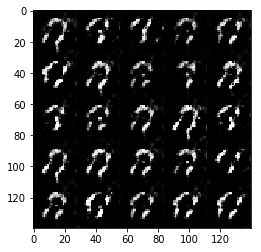

Epoch 1/2 Batch# 810... Discriminator Loss: -0.2350... Generator Loss: 4.1187
Epoch 1/2 Batch# 820... Discriminator Loss: 0.0010... Generator Loss: 3.0556
Epoch 1/2 Batch# 830... Discriminator Loss: -0.1407... Generator Loss: 6.3789
Epoch 1/2 Batch# 840... Discriminator Loss: -0.1718... Generator Loss: 3.8788
Epoch 1/2 Batch# 850... Discriminator Loss: -0.2030... Generator Loss: 4.4111
Epoch 2/2 Batch# 10... Discriminator Loss: -0.2572... Generator Loss: 6.0477
Epoch 2/2 Batch# 20... Discriminator Loss: -0.0294... Generator Loss: 6.5390
Epoch 2/2 Batch# 30... Discriminator Loss: -0.3391... Generator Loss: 7.1839
Epoch 2/2 Batch# 40... Discriminator Loss: -0.4889... Generator Loss: 7.8702
Epoch 2/2 Batch# 50... Discriminator Loss: -0.2053... Generator Loss: 5.2567
Epoch 2/2 Batch# 60... Discriminator Loss: 0.0934... Generator Loss: 8.4603
Epoch 2/2 Batch# 70... Discriminator Loss: 0.3049... Generator Loss: 11.5004
Epoch 2/2 Batch# 80... Discriminator Loss: 0.5693... Generator Loss: 3.66

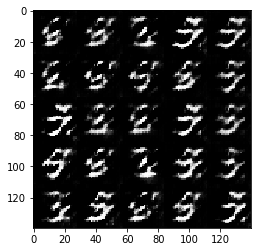

Epoch 2/2 Batch# 110... Discriminator Loss: -0.2633... Generator Loss: 4.1722
Epoch 2/2 Batch# 120... Discriminator Loss: 0.0859... Generator Loss: 4.3966
Epoch 2/2 Batch# 130... Discriminator Loss: -0.0652... Generator Loss: 4.9083
Epoch 2/2 Batch# 140... Discriminator Loss: -0.2656... Generator Loss: 5.1790
Epoch 2/2 Batch# 150... Discriminator Loss: -0.0827... Generator Loss: 3.8438
Epoch 2/2 Batch# 160... Discriminator Loss: -0.1747... Generator Loss: 6.4142
Epoch 2/2 Batch# 170... Discriminator Loss: 0.1157... Generator Loss: 3.2915
Epoch 2/2 Batch# 180... Discriminator Loss: 1.5199... Generator Loss: 11.9103
Epoch 2/2 Batch# 190... Discriminator Loss: -0.0243... Generator Loss: 3.9379
Epoch 2/2 Batch# 200... Discriminator Loss: -0.0064... Generator Loss: 5.1111


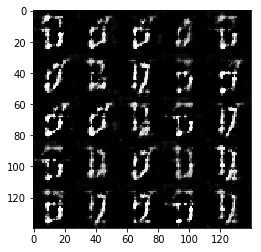

Epoch 2/2 Batch# 210... Discriminator Loss: 0.3290... Generator Loss: 3.6621
Epoch 2/2 Batch# 220... Discriminator Loss: 0.6048... Generator Loss: 2.3204
Epoch 2/2 Batch# 230... Discriminator Loss: 0.1822... Generator Loss: 3.1578
Epoch 2/2 Batch# 240... Discriminator Loss: 0.1922... Generator Loss: 3.6582
Epoch 2/2 Batch# 250... Discriminator Loss: -0.0146... Generator Loss: 4.5993
Epoch 2/2 Batch# 260... Discriminator Loss: 0.4851... Generator Loss: 3.2343
Epoch 2/2 Batch# 270... Discriminator Loss: -0.0342... Generator Loss: 3.3421
Epoch 2/2 Batch# 280... Discriminator Loss: 0.0198... Generator Loss: 4.5430
Epoch 2/2 Batch# 290... Discriminator Loss: 0.3417... Generator Loss: 5.0489
Epoch 2/2 Batch# 300... Discriminator Loss: 0.0259... Generator Loss: 4.5458


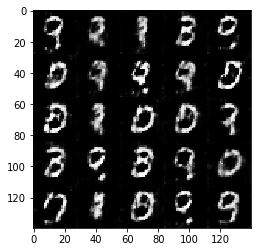

Epoch 2/2 Batch# 310... Discriminator Loss: 0.6669... Generator Loss: 1.8790
Epoch 2/2 Batch# 320... Discriminator Loss: 0.3152... Generator Loss: 4.1864
Epoch 2/2 Batch# 330... Discriminator Loss: 0.2967... Generator Loss: 3.5651
Epoch 2/2 Batch# 340... Discriminator Loss: 0.7894... Generator Loss: 1.8554
Epoch 2/2 Batch# 350... Discriminator Loss: 0.3551... Generator Loss: 3.0008
Epoch 2/2 Batch# 360... Discriminator Loss: 0.1967... Generator Loss: 3.7339
Epoch 2/2 Batch# 370... Discriminator Loss: 0.4698... Generator Loss: 2.5534
Epoch 2/2 Batch# 380... Discriminator Loss: 0.1097... Generator Loss: 3.5621
Epoch 2/2 Batch# 390... Discriminator Loss: 0.0441... Generator Loss: 3.4183
Epoch 2/2 Batch# 400... Discriminator Loss: 0.5120... Generator Loss: 2.2626


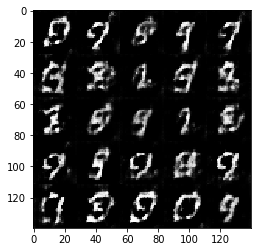

Epoch 2/2 Batch# 410... Discriminator Loss: 0.0646... Generator Loss: 4.6065
Epoch 2/2 Batch# 420... Discriminator Loss: 0.1716... Generator Loss: 3.8094
Epoch 2/2 Batch# 430... Discriminator Loss: 0.0469... Generator Loss: 4.4544
Epoch 2/2 Batch# 440... Discriminator Loss: 0.8333... Generator Loss: 1.8690
Epoch 2/2 Batch# 450... Discriminator Loss: 0.2504... Generator Loss: 3.5065
Epoch 2/2 Batch# 460... Discriminator Loss: 0.1426... Generator Loss: 3.0246
Epoch 2/2 Batch# 470... Discriminator Loss: 0.4046... Generator Loss: 3.5095
Epoch 2/2 Batch# 480... Discriminator Loss: 0.3398... Generator Loss: 4.2293
Epoch 2/2 Batch# 490... Discriminator Loss: 0.1774... Generator Loss: 2.8892
Epoch 2/2 Batch# 500... Discriminator Loss: 0.2384... Generator Loss: 2.1033


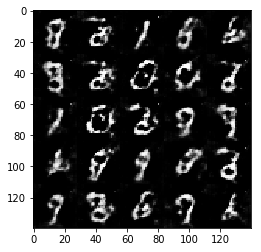

Epoch 2/2 Batch# 510... Discriminator Loss: 0.1823... Generator Loss: 3.3423
Epoch 2/2 Batch# 520... Discriminator Loss: 0.3200... Generator Loss: 2.1206
Epoch 2/2 Batch# 530... Discriminator Loss: 0.3855... Generator Loss: 2.3072
Epoch 2/2 Batch# 540... Discriminator Loss: 0.2210... Generator Loss: 4.0915
Epoch 2/2 Batch# 550... Discriminator Loss: 0.2155... Generator Loss: 3.3091
Epoch 2/2 Batch# 560... Discriminator Loss: 0.0075... Generator Loss: 2.4411
Epoch 2/2 Batch# 570... Discriminator Loss: 0.3750... Generator Loss: 2.9525
Epoch 2/2 Batch# 580... Discriminator Loss: 0.9240... Generator Loss: 4.7120
Epoch 2/2 Batch# 590... Discriminator Loss: 0.4141... Generator Loss: 1.9283
Epoch 2/2 Batch# 600... Discriminator Loss: 0.5697... Generator Loss: 1.9490


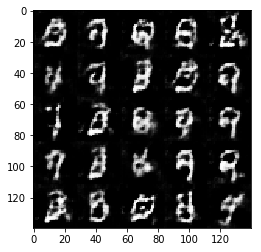

Epoch 2/2 Batch# 610... Discriminator Loss: 0.3182... Generator Loss: 3.8397
Epoch 2/2 Batch# 620... Discriminator Loss: 0.2381... Generator Loss: 2.0776
Epoch 2/2 Batch# 630... Discriminator Loss: 0.4756... Generator Loss: 2.4647
Epoch 2/2 Batch# 640... Discriminator Loss: 0.4258... Generator Loss: 2.5473
Epoch 2/2 Batch# 650... Discriminator Loss: 0.4633... Generator Loss: 1.7980
Epoch 2/2 Batch# 660... Discriminator Loss: 0.2167... Generator Loss: 3.5518
Epoch 2/2 Batch# 670... Discriminator Loss: 1.0768... Generator Loss: 6.0166
Epoch 2/2 Batch# 680... Discriminator Loss: 0.8049... Generator Loss: 1.8599
Epoch 2/2 Batch# 690... Discriminator Loss: 0.6964... Generator Loss: 1.2124
Epoch 2/2 Batch# 700... Discriminator Loss: 0.2027... Generator Loss: 2.7900


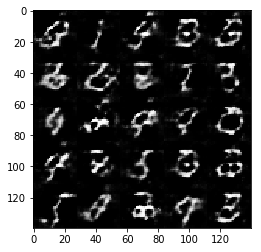

Epoch 2/2 Batch# 710... Discriminator Loss: 0.5931... Generator Loss: 3.1540
Epoch 2/2 Batch# 720... Discriminator Loss: 0.4904... Generator Loss: 4.0567
Epoch 2/2 Batch# 730... Discriminator Loss: 0.0599... Generator Loss: 4.3603
Epoch 2/2 Batch# 740... Discriminator Loss: 0.4184... Generator Loss: 2.4528
Epoch 2/2 Batch# 750... Discriminator Loss: 0.4322... Generator Loss: 2.8368
Epoch 2/2 Batch# 760... Discriminator Loss: 0.6467... Generator Loss: 2.4602
Epoch 2/2 Batch# 770... Discriminator Loss: 0.5527... Generator Loss: 1.8476
Epoch 2/2 Batch# 780... Discriminator Loss: 0.5608... Generator Loss: 1.8153
Epoch 2/2 Batch# 790... Discriminator Loss: 1.2440... Generator Loss: 3.5972
Epoch 2/2 Batch# 800... Discriminator Loss: 0.4045... Generator Loss: 3.1906


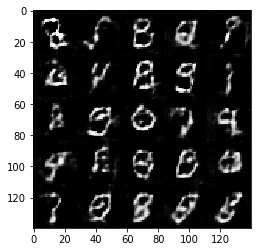

Epoch 2/2 Batch# 810... Discriminator Loss: 0.4567... Generator Loss: 2.4311
Epoch 2/2 Batch# 820... Discriminator Loss: 0.8263... Generator Loss: 2.4585
Epoch 2/2 Batch# 830... Discriminator Loss: 0.5669... Generator Loss: 1.8213
Epoch 2/2 Batch# 840... Discriminator Loss: 0.4544... Generator Loss: 2.3025
Epoch 2/2 Batch# 850... Discriminator Loss: 0.5709... Generator Loss: 2.0413


In [44]:
batch_size = 70
z_dim = 100
learning_rate = 0.0002
beta1 = 0.6


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1 Batch# 10... Discriminator Loss: 0.3052... Generator Loss: 1.0967
Epoch 1/1 Batch# 20... Discriminator Loss: 1.2739... Generator Loss: 0.2139
Epoch 1/1 Batch# 30... Discriminator Loss: -0.2663... Generator Loss: 2.0927
Epoch 1/1 Batch# 40... Discriminator Loss: -0.1181... Generator Loss: 8.3199
Epoch 1/1 Batch# 50... Discriminator Loss: -0.4931... Generator Loss: 5.5206
Epoch 1/1 Batch# 60... Discriminator Loss: 0.3681... Generator Loss: 2.4623
Epoch 1/1 Batch# 70... Discriminator Loss: -0.3882... Generator Loss: 2.6150
Epoch 1/1 Batch# 80... Discriminator Loss: -0.4250... Generator Loss: 1.3599
Epoch 1/1 Batch# 90... Discriminator Loss: -1.0074... Generator Loss: 3.3125
Epoch 1/1 Batch# 100... Discriminator Loss: 0.6995... Generator Loss: 0.9737


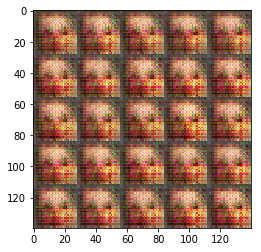

Epoch 1/1 Batch# 110... Discriminator Loss: -0.6789... Generator Loss: 2.8037
Epoch 1/1 Batch# 120... Discriminator Loss: -0.6283... Generator Loss: 1.3608
Epoch 1/1 Batch# 130... Discriminator Loss: 0.8826... Generator Loss: 17.4697
Epoch 1/1 Batch# 140... Discriminator Loss: 0.4227... Generator Loss: 0.2583
Epoch 1/1 Batch# 150... Discriminator Loss: -0.3058... Generator Loss: 11.5042
Epoch 1/1 Batch# 160... Discriminator Loss: -0.8104... Generator Loss: 1.3298
Epoch 1/1 Batch# 170... Discriminator Loss: -1.0895... Generator Loss: 1.8018
Epoch 1/1 Batch# 180... Discriminator Loss: 0.1224... Generator Loss: 0.4036
Epoch 1/1 Batch# 190... Discriminator Loss: -1.9679... Generator Loss: 15.0345
Epoch 1/1 Batch# 200... Discriminator Loss: -2.3643... Generator Loss: 6.6087


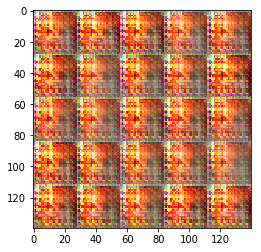

Epoch 1/1 Batch# 210... Discriminator Loss: -2.4334... Generator Loss: 16.8121
Epoch 1/1 Batch# 220... Discriminator Loss: -2.6016... Generator Loss: 12.0790
Epoch 1/1 Batch# 230... Discriminator Loss: 0.7109... Generator Loss: 17.6963
Epoch 1/1 Batch# 240... Discriminator Loss: -2.0899... Generator Loss: 16.4985
Epoch 1/1 Batch# 250... Discriminator Loss: -0.4635... Generator Loss: 5.3859
Epoch 1/1 Batch# 260... Discriminator Loss: 0.3422... Generator Loss: 1.1055
Epoch 1/1 Batch# 270... Discriminator Loss: -0.0038... Generator Loss: 1.9686
Epoch 1/1 Batch# 280... Discriminator Loss: 0.4067... Generator Loss: 1.9186
Epoch 1/1 Batch# 290... Discriminator Loss: 2.2400... Generator Loss: 2.7728
Epoch 1/1 Batch# 300... Discriminator Loss: 0.2800... Generator Loss: 0.7651


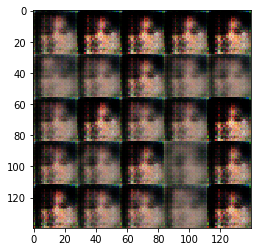

Epoch 1/1 Batch# 310... Discriminator Loss: 0.3287... Generator Loss: 1.9194
Epoch 1/1 Batch# 320... Discriminator Loss: 0.3229... Generator Loss: 2.5101
Epoch 1/1 Batch# 330... Discriminator Loss: 1.0614... Generator Loss: 0.4181
Epoch 1/1 Batch# 340... Discriminator Loss: 1.8786... Generator Loss: 0.3806
Epoch 1/1 Batch# 350... Discriminator Loss: 2.2726... Generator Loss: 0.7277
Epoch 1/1 Batch# 360... Discriminator Loss: 0.9743... Generator Loss: 0.9620
Epoch 1/1 Batch# 370... Discriminator Loss: 0.9848... Generator Loss: 0.9100
Epoch 1/1 Batch# 380... Discriminator Loss: 0.5278... Generator Loss: 0.9884
Epoch 1/1 Batch# 390... Discriminator Loss: 1.0736... Generator Loss: 0.7567
Epoch 1/1 Batch# 400... Discriminator Loss: 0.7776... Generator Loss: 1.0620


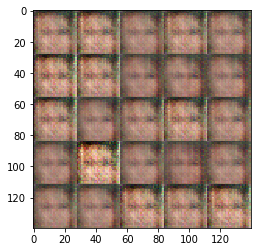

Epoch 1/1 Batch# 410... Discriminator Loss: 0.0757... Generator Loss: 1.7423
Epoch 1/1 Batch# 420... Discriminator Loss: 1.4956... Generator Loss: 0.8279
Epoch 1/1 Batch# 430... Discriminator Loss: 0.8166... Generator Loss: 0.9471
Epoch 1/1 Batch# 440... Discriminator Loss: 0.8079... Generator Loss: 1.1824
Epoch 1/1 Batch# 450... Discriminator Loss: 1.8482... Generator Loss: 0.8184
Epoch 1/1 Batch# 460... Discriminator Loss: 1.8259... Generator Loss: 0.7460
Epoch 1/1 Batch# 470... Discriminator Loss: 1.3830... Generator Loss: 0.6216
Epoch 1/1 Batch# 480... Discriminator Loss: 0.8588... Generator Loss: 0.9479
Epoch 1/1 Batch# 490... Discriminator Loss: 0.3196... Generator Loss: 1.3980
Epoch 1/1 Batch# 500... Discriminator Loss: 0.6303... Generator Loss: 1.0157


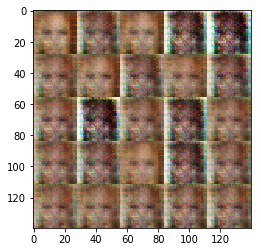

Epoch 1/1 Batch# 510... Discriminator Loss: 0.6802... Generator Loss: 1.3690
Epoch 1/1 Batch# 520... Discriminator Loss: 1.8672... Generator Loss: 0.9684
Epoch 1/1 Batch# 530... Discriminator Loss: 0.7293... Generator Loss: 1.1995
Epoch 1/1 Batch# 540... Discriminator Loss: 1.0631... Generator Loss: 0.9968
Epoch 1/1 Batch# 550... Discriminator Loss: 0.7271... Generator Loss: 1.2908
Epoch 1/1 Batch# 560... Discriminator Loss: 1.1812... Generator Loss: 0.8941
Epoch 1/1 Batch# 570... Discriminator Loss: 1.8886... Generator Loss: 0.5424
Epoch 1/1 Batch# 580... Discriminator Loss: 1.2828... Generator Loss: 0.6839
Epoch 1/1 Batch# 590... Discriminator Loss: 0.1438... Generator Loss: 1.3127
Epoch 1/1 Batch# 600... Discriminator Loss: 0.4370... Generator Loss: 1.2039


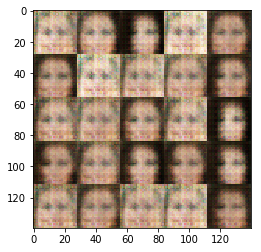

Epoch 1/1 Batch# 610... Discriminator Loss: 1.4731... Generator Loss: 0.5046
Epoch 1/1 Batch# 620... Discriminator Loss: 1.2862... Generator Loss: 0.7291
Epoch 1/1 Batch# 630... Discriminator Loss: 0.7182... Generator Loss: 1.2103
Epoch 1/1 Batch# 640... Discriminator Loss: 0.6325... Generator Loss: 1.0674
Epoch 1/1 Batch# 650... Discriminator Loss: 1.1660... Generator Loss: 0.9523
Epoch 1/1 Batch# 660... Discriminator Loss: 0.8430... Generator Loss: 1.0320
Epoch 1/1 Batch# 670... Discriminator Loss: 1.2009... Generator Loss: 0.7901
Epoch 1/1 Batch# 680... Discriminator Loss: 0.6882... Generator Loss: 1.3240
Epoch 1/1 Batch# 690... Discriminator Loss: 0.7849... Generator Loss: 1.3084
Epoch 1/1 Batch# 700... Discriminator Loss: 0.8086... Generator Loss: 0.9855


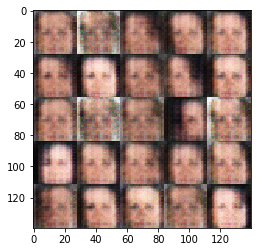

Epoch 1/1 Batch# 710... Discriminator Loss: 0.7612... Generator Loss: 0.9720
Epoch 1/1 Batch# 720... Discriminator Loss: 1.2847... Generator Loss: 0.6688
Epoch 1/1 Batch# 730... Discriminator Loss: 1.3040... Generator Loss: 1.1522
Epoch 1/1 Batch# 740... Discriminator Loss: 1.3930... Generator Loss: 0.4986
Epoch 1/1 Batch# 750... Discriminator Loss: 1.3923... Generator Loss: 0.4629
Epoch 1/1 Batch# 760... Discriminator Loss: 0.6278... Generator Loss: 1.1476
Epoch 1/1 Batch# 770... Discriminator Loss: 0.8935... Generator Loss: 0.7333
Epoch 1/1 Batch# 780... Discriminator Loss: 0.5540... Generator Loss: 1.4204
Epoch 1/1 Batch# 790... Discriminator Loss: 0.6368... Generator Loss: 1.3862
Epoch 1/1 Batch# 800... Discriminator Loss: 1.4345... Generator Loss: 0.4146


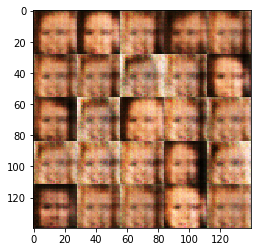

Epoch 1/1 Batch# 810... Discriminator Loss: 0.8051... Generator Loss: 0.8187
Epoch 1/1 Batch# 820... Discriminator Loss: 0.8719... Generator Loss: 0.6819
Epoch 1/1 Batch# 830... Discriminator Loss: 1.2492... Generator Loss: 0.7753
Epoch 1/1 Batch# 840... Discriminator Loss: 0.8069... Generator Loss: 0.6087
Epoch 1/1 Batch# 850... Discriminator Loss: 1.3208... Generator Loss: 1.0069
Epoch 1/1 Batch# 860... Discriminator Loss: 0.9764... Generator Loss: 1.0689
Epoch 1/1 Batch# 870... Discriminator Loss: 0.6192... Generator Loss: 0.9743
Epoch 1/1 Batch# 880... Discriminator Loss: 1.1114... Generator Loss: 0.8241
Epoch 1/1 Batch# 890... Discriminator Loss: 0.8055... Generator Loss: 1.2016
Epoch 1/1 Batch# 900... Discriminator Loss: 0.5869... Generator Loss: 1.2860


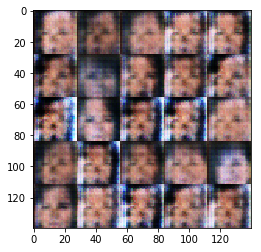

Epoch 1/1 Batch# 910... Discriminator Loss: 1.1382... Generator Loss: 0.7028
Epoch 1/1 Batch# 920... Discriminator Loss: 1.0420... Generator Loss: 1.1114
Epoch 1/1 Batch# 930... Discriminator Loss: 0.7141... Generator Loss: 1.3510
Epoch 1/1 Batch# 940... Discriminator Loss: 0.9186... Generator Loss: 1.3571
Epoch 1/1 Batch# 950... Discriminator Loss: 0.7304... Generator Loss: 1.2700
Epoch 1/1 Batch# 960... Discriminator Loss: 1.3855... Generator Loss: 0.5853
Epoch 1/1 Batch# 970... Discriminator Loss: 1.0292... Generator Loss: 0.6188
Epoch 1/1 Batch# 980... Discriminator Loss: 0.8092... Generator Loss: 0.7706
Epoch 1/1 Batch# 990... Discriminator Loss: 1.3877... Generator Loss: 0.6368
Epoch 1/1 Batch# 1000... Discriminator Loss: 0.4455... Generator Loss: 1.7699


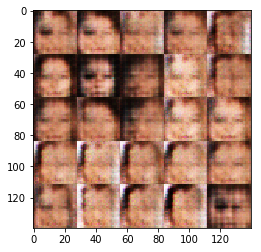

Epoch 1/1 Batch# 1010... Discriminator Loss: 0.5452... Generator Loss: 1.2132
Epoch 1/1 Batch# 1020... Discriminator Loss: 1.1354... Generator Loss: 0.8333
Epoch 1/1 Batch# 1030... Discriminator Loss: 0.7772... Generator Loss: 0.8072
Epoch 1/1 Batch# 1040... Discriminator Loss: 0.7585... Generator Loss: 1.0576
Epoch 1/1 Batch# 1050... Discriminator Loss: 0.9500... Generator Loss: 0.7171
Epoch 1/1 Batch# 1060... Discriminator Loss: 0.4145... Generator Loss: 2.2965
Epoch 1/1 Batch# 1070... Discriminator Loss: 0.6893... Generator Loss: 1.1959
Epoch 1/1 Batch# 1080... Discriminator Loss: 2.0930... Generator Loss: 0.2520
Epoch 1/1 Batch# 1090... Discriminator Loss: 1.5906... Generator Loss: 1.0381
Epoch 1/1 Batch# 1100... Discriminator Loss: 0.8910... Generator Loss: 0.6396


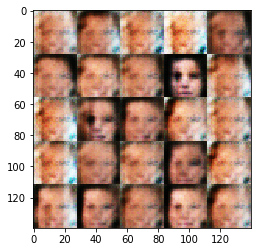

Epoch 1/1 Batch# 1110... Discriminator Loss: 1.0363... Generator Loss: 0.8665
Epoch 1/1 Batch# 1120... Discriminator Loss: 0.9896... Generator Loss: 0.7849
Epoch 1/1 Batch# 1130... Discriminator Loss: 0.6900... Generator Loss: 0.9542
Epoch 1/1 Batch# 1140... Discriminator Loss: 1.1671... Generator Loss: 0.5977
Epoch 1/1 Batch# 1150... Discriminator Loss: 0.6344... Generator Loss: 1.7225
Epoch 1/1 Batch# 1160... Discriminator Loss: 0.7120... Generator Loss: 1.2372
Epoch 1/1 Batch# 1170... Discriminator Loss: 0.4251... Generator Loss: 1.7882
Epoch 1/1 Batch# 1180... Discriminator Loss: 0.6957... Generator Loss: 1.3947
Epoch 1/1 Batch# 1190... Discriminator Loss: 0.8509... Generator Loss: 0.8993
Epoch 1/1 Batch# 1200... Discriminator Loss: 1.2693... Generator Loss: 1.1568


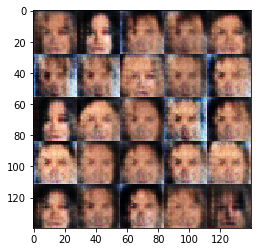

Epoch 1/1 Batch# 1210... Discriminator Loss: 1.0392... Generator Loss: 0.8348
Epoch 1/1 Batch# 1220... Discriminator Loss: 0.7404... Generator Loss: 1.4324
Epoch 1/1 Batch# 1230... Discriminator Loss: 0.9117... Generator Loss: 1.1666
Epoch 1/1 Batch# 1240... Discriminator Loss: 0.9572... Generator Loss: 1.0869
Epoch 1/1 Batch# 1250... Discriminator Loss: 1.0070... Generator Loss: 1.5794
Epoch 1/1 Batch# 1260... Discriminator Loss: 0.8707... Generator Loss: 1.2410
Epoch 1/1 Batch# 1270... Discriminator Loss: 0.8886... Generator Loss: 1.1157
Epoch 1/1 Batch# 1280... Discriminator Loss: 0.9127... Generator Loss: 1.2385
Epoch 1/1 Batch# 1290... Discriminator Loss: 0.3607... Generator Loss: 1.8332
Epoch 1/1 Batch# 1300... Discriminator Loss: 1.2784... Generator Loss: 0.9161


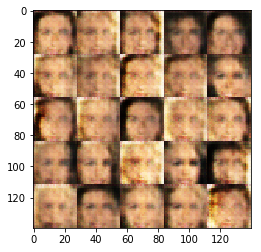

Epoch 1/1 Batch# 1310... Discriminator Loss: 0.8138... Generator Loss: 0.5607
Epoch 1/1 Batch# 1320... Discriminator Loss: 0.7378... Generator Loss: 1.3099
Epoch 1/1 Batch# 1330... Discriminator Loss: 1.1267... Generator Loss: 1.1614
Epoch 1/1 Batch# 1340... Discriminator Loss: 0.6042... Generator Loss: 0.9382
Epoch 1/1 Batch# 1350... Discriminator Loss: 0.7802... Generator Loss: 1.0035
Epoch 1/1 Batch# 1360... Discriminator Loss: 0.7521... Generator Loss: 1.0655
Epoch 1/1 Batch# 1370... Discriminator Loss: 0.7820... Generator Loss: 1.5727
Epoch 1/1 Batch# 1380... Discriminator Loss: 1.1974... Generator Loss: 0.5962
Epoch 1/1 Batch# 1390... Discriminator Loss: 0.7767... Generator Loss: 0.9875
Epoch 1/1 Batch# 1400... Discriminator Loss: 1.1307... Generator Loss: 0.5594


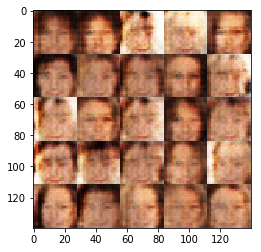

Epoch 1/1 Batch# 1410... Discriminator Loss: 1.0411... Generator Loss: 0.7804
Epoch 1/1 Batch# 1420... Discriminator Loss: 0.8144... Generator Loss: 0.9330
Epoch 1/1 Batch# 1430... Discriminator Loss: 1.3970... Generator Loss: 0.9067
Epoch 1/1 Batch# 1440... Discriminator Loss: 1.1254... Generator Loss: 0.7337
Epoch 1/1 Batch# 1450... Discriminator Loss: 0.6681... Generator Loss: 0.8378
Epoch 1/1 Batch# 1460... Discriminator Loss: 1.3784... Generator Loss: 0.7489
Epoch 1/1 Batch# 1470... Discriminator Loss: 0.8754... Generator Loss: 1.1075
Epoch 1/1 Batch# 1480... Discriminator Loss: 1.1035... Generator Loss: 1.2977
Epoch 1/1 Batch# 1490... Discriminator Loss: 0.6193... Generator Loss: 1.0549
Epoch 1/1 Batch# 1500... Discriminator Loss: 1.2461... Generator Loss: 0.6696


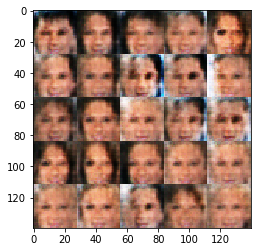

Epoch 1/1 Batch# 1510... Discriminator Loss: 1.5751... Generator Loss: 0.4075
Epoch 1/1 Batch# 1520... Discriminator Loss: 0.8811... Generator Loss: 0.6629
Epoch 1/1 Batch# 1530... Discriminator Loss: 1.5319... Generator Loss: 0.3982
Epoch 1/1 Batch# 1540... Discriminator Loss: 1.1933... Generator Loss: 0.9505
Epoch 1/1 Batch# 1550... Discriminator Loss: 1.0224... Generator Loss: 0.8015
Epoch 1/1 Batch# 1560... Discriminator Loss: 0.7814... Generator Loss: 1.1019
Epoch 1/1 Batch# 1570... Discriminator Loss: 0.8071... Generator Loss: 1.0227
Epoch 1/1 Batch# 1580... Discriminator Loss: 1.1327... Generator Loss: 1.2156
Epoch 1/1 Batch# 1590... Discriminator Loss: 1.3287... Generator Loss: 0.5426
Epoch 1/1 Batch# 1600... Discriminator Loss: 0.8143... Generator Loss: 0.7689


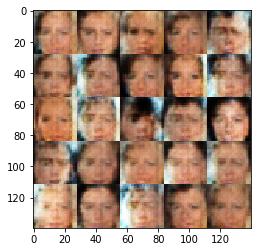

Epoch 1/1 Batch# 1610... Discriminator Loss: 0.8565... Generator Loss: 0.8206
Epoch 1/1 Batch# 1620... Discriminator Loss: 0.7979... Generator Loss: 1.2460
Epoch 1/1 Batch# 1630... Discriminator Loss: 0.5578... Generator Loss: 1.6766
Epoch 1/1 Batch# 1640... Discriminator Loss: 1.1869... Generator Loss: 0.4507
Epoch 1/1 Batch# 1650... Discriminator Loss: 0.8702... Generator Loss: 0.8453
Epoch 1/1 Batch# 1660... Discriminator Loss: 0.8394... Generator Loss: 1.9543
Epoch 1/1 Batch# 1670... Discriminator Loss: 1.3492... Generator Loss: 0.4374
Epoch 1/1 Batch# 1680... Discriminator Loss: 0.7422... Generator Loss: 1.3753
Epoch 1/1 Batch# 1690... Discriminator Loss: 0.4025... Generator Loss: 1.7092
Epoch 1/1 Batch# 1700... Discriminator Loss: 1.1237... Generator Loss: 0.7354


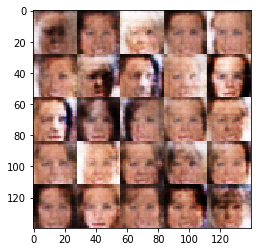

Epoch 1/1 Batch# 1710... Discriminator Loss: 1.2427... Generator Loss: 0.4787
Epoch 1/1 Batch# 1720... Discriminator Loss: 0.7673... Generator Loss: 1.0742
Epoch 1/1 Batch# 1730... Discriminator Loss: 1.2431... Generator Loss: 0.6034
Epoch 1/1 Batch# 1740... Discriminator Loss: 1.1318... Generator Loss: 1.4584
Epoch 1/1 Batch# 1750... Discriminator Loss: 0.8196... Generator Loss: 1.2799
Epoch 1/1 Batch# 1760... Discriminator Loss: 1.4463... Generator Loss: 1.0965
Epoch 1/1 Batch# 1770... Discriminator Loss: 1.0839... Generator Loss: 1.5081
Epoch 1/1 Batch# 1780... Discriminator Loss: 1.4714... Generator Loss: 0.6700
Epoch 1/1 Batch# 1790... Discriminator Loss: 1.3710... Generator Loss: 1.0664
Epoch 1/1 Batch# 1800... Discriminator Loss: 1.2617... Generator Loss: 0.6723


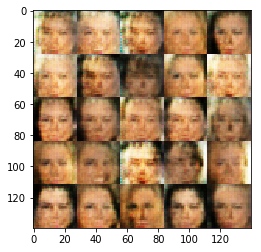

Epoch 1/1 Batch# 1810... Discriminator Loss: 1.1370... Generator Loss: 0.5114
Epoch 1/1 Batch# 1820... Discriminator Loss: 1.1750... Generator Loss: 0.5147
Epoch 1/1 Batch# 1830... Discriminator Loss: 1.9906... Generator Loss: 0.2580
Epoch 1/1 Batch# 1840... Discriminator Loss: 1.0770... Generator Loss: 0.9502
Epoch 1/1 Batch# 1850... Discriminator Loss: 0.9518... Generator Loss: 1.2720
Epoch 1/1 Batch# 1860... Discriminator Loss: 1.3678... Generator Loss: 0.7249
Epoch 1/1 Batch# 1870... Discriminator Loss: 1.0360... Generator Loss: 0.9013
Epoch 1/1 Batch# 1880... Discriminator Loss: 1.0432... Generator Loss: 0.9372
Epoch 1/1 Batch# 1890... Discriminator Loss: 1.0849... Generator Loss: 0.4440
Epoch 1/1 Batch# 1900... Discriminator Loss: 1.5709... Generator Loss: 0.6770


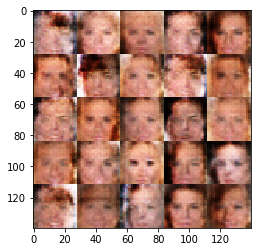

Epoch 1/1 Batch# 1910... Discriminator Loss: 1.0673... Generator Loss: 0.8782
Epoch 1/1 Batch# 1920... Discriminator Loss: 0.8827... Generator Loss: 0.9679
Epoch 1/1 Batch# 1930... Discriminator Loss: 1.7761... Generator Loss: 0.3884
Epoch 1/1 Batch# 1940... Discriminator Loss: 0.8160... Generator Loss: 1.2881
Epoch 1/1 Batch# 1950... Discriminator Loss: 1.0281... Generator Loss: 0.7894
Epoch 1/1 Batch# 1960... Discriminator Loss: 0.8106... Generator Loss: 0.8988
Epoch 1/1 Batch# 1970... Discriminator Loss: 0.9265... Generator Loss: 0.6269
Epoch 1/1 Batch# 1980... Discriminator Loss: 1.7818... Generator Loss: 0.2374
Epoch 1/1 Batch# 1990... Discriminator Loss: 0.8898... Generator Loss: 1.3079
Epoch 1/1 Batch# 2000... Discriminator Loss: 0.9193... Generator Loss: 0.8965


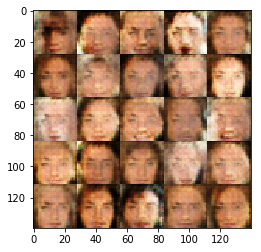

Epoch 1/1 Batch# 2010... Discriminator Loss: 1.1937... Generator Loss: 0.5506
Epoch 1/1 Batch# 2020... Discriminator Loss: 1.0470... Generator Loss: 1.0453
Epoch 1/1 Batch# 2030... Discriminator Loss: 0.7958... Generator Loss: 1.4034
Epoch 1/1 Batch# 2040... Discriminator Loss: 0.9615... Generator Loss: 0.7794
Epoch 1/1 Batch# 2050... Discriminator Loss: 0.7235... Generator Loss: 1.8595
Epoch 1/1 Batch# 2060... Discriminator Loss: 0.7354... Generator Loss: 1.2422
Epoch 1/1 Batch# 2070... Discriminator Loss: 0.9286... Generator Loss: 1.0411
Epoch 1/1 Batch# 2080... Discriminator Loss: 0.9564... Generator Loss: 1.9992
Epoch 1/1 Batch# 2090... Discriminator Loss: 1.2226... Generator Loss: 0.7339
Epoch 1/1 Batch# 2100... Discriminator Loss: 1.1773... Generator Loss: 1.1123


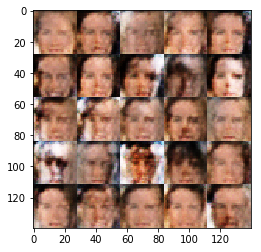

Epoch 1/1 Batch# 2110... Discriminator Loss: 0.5978... Generator Loss: 1.5511
Epoch 1/1 Batch# 2120... Discriminator Loss: 0.9405... Generator Loss: 1.1991
Epoch 1/1 Batch# 2130... Discriminator Loss: 1.5027... Generator Loss: 0.3293
Epoch 1/1 Batch# 2140... Discriminator Loss: 0.9496... Generator Loss: 1.0493
Epoch 1/1 Batch# 2150... Discriminator Loss: 1.3897... Generator Loss: 0.6264
Epoch 1/1 Batch# 2160... Discriminator Loss: 0.6580... Generator Loss: 1.4511
Epoch 1/1 Batch# 2170... Discriminator Loss: 0.6594... Generator Loss: 2.2024
Epoch 1/1 Batch# 2180... Discriminator Loss: 0.9021... Generator Loss: 0.7704
Epoch 1/1 Batch# 2190... Discriminator Loss: 0.7239... Generator Loss: 0.9460
Epoch 1/1 Batch# 2200... Discriminator Loss: 0.8560... Generator Loss: 1.0862


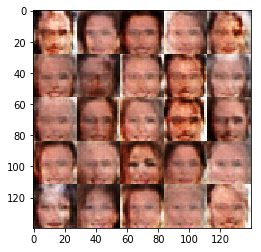

Epoch 1/1 Batch# 2210... Discriminator Loss: 1.4384... Generator Loss: 1.2081
Epoch 1/1 Batch# 2220... Discriminator Loss: 1.1216... Generator Loss: 0.5917
Epoch 1/1 Batch# 2230... Discriminator Loss: 1.1096... Generator Loss: 0.6821
Epoch 1/1 Batch# 2240... Discriminator Loss: 1.6604... Generator Loss: 0.3016
Epoch 1/1 Batch# 2250... Discriminator Loss: 0.9332... Generator Loss: 0.5197
Epoch 1/1 Batch# 2260... Discriminator Loss: 1.0585... Generator Loss: 0.5347
Epoch 1/1 Batch# 2270... Discriminator Loss: 1.2454... Generator Loss: 0.7922
Epoch 1/1 Batch# 2280... Discriminator Loss: 1.1625... Generator Loss: 0.3730
Epoch 1/1 Batch# 2290... Discriminator Loss: 1.1479... Generator Loss: 1.3405
Epoch 1/1 Batch# 2300... Discriminator Loss: 1.6258... Generator Loss: 0.4737


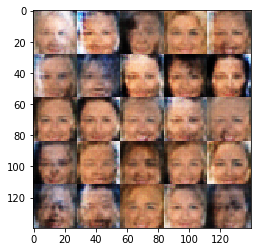

Epoch 1/1 Batch# 2310... Discriminator Loss: 1.0654... Generator Loss: 0.7164
Epoch 1/1 Batch# 2320... Discriminator Loss: 1.0545... Generator Loss: 0.5728
Epoch 1/1 Batch# 2330... Discriminator Loss: 1.1874... Generator Loss: 0.8196
Epoch 1/1 Batch# 2340... Discriminator Loss: 1.0575... Generator Loss: 0.9251
Epoch 1/1 Batch# 2350... Discriminator Loss: 0.8502... Generator Loss: 1.6009
Epoch 1/1 Batch# 2360... Discriminator Loss: 0.6105... Generator Loss: 1.5742
Epoch 1/1 Batch# 2370... Discriminator Loss: 0.8589... Generator Loss: 1.1620
Epoch 1/1 Batch# 2380... Discriminator Loss: 0.8221... Generator Loss: 1.4354
Epoch 1/1 Batch# 2390... Discriminator Loss: 0.8855... Generator Loss: 1.5704
Epoch 1/1 Batch# 2400... Discriminator Loss: 0.9012... Generator Loss: 0.6293


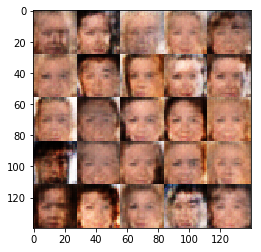

Epoch 1/1 Batch# 2410... Discriminator Loss: 1.1494... Generator Loss: 1.0508
Epoch 1/1 Batch# 2420... Discriminator Loss: 0.8057... Generator Loss: 1.0977
Epoch 1/1 Batch# 2430... Discriminator Loss: 0.6540... Generator Loss: 1.3215
Epoch 1/1 Batch# 2440... Discriminator Loss: 0.9783... Generator Loss: 1.4526
Epoch 1/1 Batch# 2450... Discriminator Loss: 1.2367... Generator Loss: 0.4530
Epoch 1/1 Batch# 2460... Discriminator Loss: 1.0313... Generator Loss: 0.7961
Epoch 1/1 Batch# 2470... Discriminator Loss: 0.5961... Generator Loss: 1.6421
Epoch 1/1 Batch# 2480... Discriminator Loss: 1.0665... Generator Loss: 0.8827
Epoch 1/1 Batch# 2490... Discriminator Loss: 0.7607... Generator Loss: 0.7126
Epoch 1/1 Batch# 2500... Discriminator Loss: 1.0759... Generator Loss: 0.7721


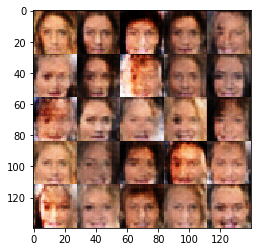

Epoch 1/1 Batch# 2510... Discriminator Loss: 0.7759... Generator Loss: 1.2406
Epoch 1/1 Batch# 2520... Discriminator Loss: 1.1042... Generator Loss: 1.1987
Epoch 1/1 Batch# 2530... Discriminator Loss: 0.8631... Generator Loss: 2.1751
Epoch 1/1 Batch# 2540... Discriminator Loss: 1.0823... Generator Loss: 1.0104
Epoch 1/1 Batch# 2550... Discriminator Loss: 0.9366... Generator Loss: 1.1276
Epoch 1/1 Batch# 2560... Discriminator Loss: 1.4121... Generator Loss: 0.9578
Epoch 1/1 Batch# 2570... Discriminator Loss: 1.6526... Generator Loss: 0.5666
Epoch 1/1 Batch# 2580... Discriminator Loss: 1.3039... Generator Loss: 0.4284
Epoch 1/1 Batch# 2590... Discriminator Loss: 1.4084... Generator Loss: 0.5560
Epoch 1/1 Batch# 2600... Discriminator Loss: 0.8562... Generator Loss: 0.9328


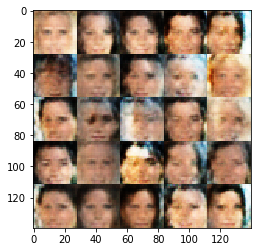

Epoch 1/1 Batch# 2610... Discriminator Loss: 1.3744... Generator Loss: 0.5274
Epoch 1/1 Batch# 2620... Discriminator Loss: 1.0891... Generator Loss: 1.0029
Epoch 1/1 Batch# 2630... Discriminator Loss: 0.9729... Generator Loss: 0.7848
Epoch 1/1 Batch# 2640... Discriminator Loss: 0.9914... Generator Loss: 0.4112
Epoch 1/1 Batch# 2650... Discriminator Loss: 1.0900... Generator Loss: 0.6892
Epoch 1/1 Batch# 2660... Discriminator Loss: 0.9124... Generator Loss: 0.8063
Epoch 1/1 Batch# 2670... Discriminator Loss: 0.7939... Generator Loss: 0.8976
Epoch 1/1 Batch# 2680... Discriminator Loss: 0.5141... Generator Loss: 1.9621
Epoch 1/1 Batch# 2690... Discriminator Loss: 0.8144... Generator Loss: 1.2667
Epoch 1/1 Batch# 2700... Discriminator Loss: 0.6814... Generator Loss: 0.8416


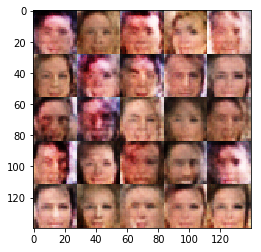

Epoch 1/1 Batch# 2710... Discriminator Loss: 1.0439... Generator Loss: 0.7803
Epoch 1/1 Batch# 2720... Discriminator Loss: 1.6464... Generator Loss: 0.3304
Epoch 1/1 Batch# 2730... Discriminator Loss: 0.7996... Generator Loss: 2.1527
Epoch 1/1 Batch# 2740... Discriminator Loss: 1.0725... Generator Loss: 1.1172
Epoch 1/1 Batch# 2750... Discriminator Loss: 0.9870... Generator Loss: 1.0814
Epoch 1/1 Batch# 2760... Discriminator Loss: 1.3735... Generator Loss: 0.4656
Epoch 1/1 Batch# 2770... Discriminator Loss: 0.9965... Generator Loss: 0.8469
Epoch 1/1 Batch# 2780... Discriminator Loss: 1.1615... Generator Loss: 0.5302
Epoch 1/1 Batch# 2790... Discriminator Loss: 1.0467... Generator Loss: 0.9052
Epoch 1/1 Batch# 2800... Discriminator Loss: 0.7203... Generator Loss: 1.1617


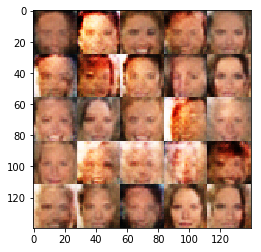

Epoch 1/1 Batch# 2810... Discriminator Loss: 1.3444... Generator Loss: 0.7086
Epoch 1/1 Batch# 2820... Discriminator Loss: 1.1286... Generator Loss: 0.8483
Epoch 1/1 Batch# 2830... Discriminator Loss: 0.8222... Generator Loss: 0.8954
Epoch 1/1 Batch# 2840... Discriminator Loss: 1.4768... Generator Loss: 1.1216
Epoch 1/1 Batch# 2850... Discriminator Loss: 0.6897... Generator Loss: 0.9254
Epoch 1/1 Batch# 2860... Discriminator Loss: 0.9271... Generator Loss: 0.9154
Epoch 1/1 Batch# 2870... Discriminator Loss: 0.4111... Generator Loss: 2.0029
Epoch 1/1 Batch# 2880... Discriminator Loss: 1.2090... Generator Loss: 0.7777
Epoch 1/1 Batch# 2890... Discriminator Loss: 0.6522... Generator Loss: 0.7679
Epoch 1/1 Batch# 2900... Discriminator Loss: 0.5245... Generator Loss: 1.0845


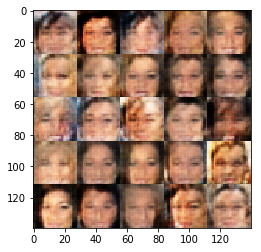

Epoch 1/1 Batch# 2910... Discriminator Loss: 1.3275... Generator Loss: 0.5411
Epoch 1/1 Batch# 2920... Discriminator Loss: 1.0948... Generator Loss: 0.6851
Epoch 1/1 Batch# 2930... Discriminator Loss: 0.9118... Generator Loss: 0.9319
Epoch 1/1 Batch# 2940... Discriminator Loss: 1.2479... Generator Loss: 0.5756
Epoch 1/1 Batch# 2950... Discriminator Loss: 1.2076... Generator Loss: 1.6057
Epoch 1/1 Batch# 2960... Discriminator Loss: 0.9892... Generator Loss: 0.6662
Epoch 1/1 Batch# 2970... Discriminator Loss: 1.3653... Generator Loss: 0.3718
Epoch 1/1 Batch# 2980... Discriminator Loss: 0.7410... Generator Loss: 0.9997
Epoch 1/1 Batch# 2990... Discriminator Loss: 1.0231... Generator Loss: 0.7050
Epoch 1/1 Batch# 3000... Discriminator Loss: 1.2875... Generator Loss: 0.4941


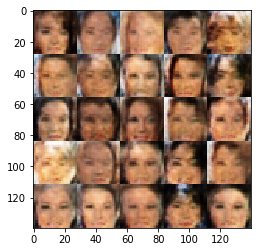

Epoch 1/1 Batch# 3010... Discriminator Loss: 1.0835... Generator Loss: 0.6665
Epoch 1/1 Batch# 3020... Discriminator Loss: 0.6520... Generator Loss: 0.9527
Epoch 1/1 Batch# 3030... Discriminator Loss: 1.3111... Generator Loss: 0.4114
Epoch 1/1 Batch# 3040... Discriminator Loss: 1.0264... Generator Loss: 0.8650
Epoch 1/1 Batch# 3050... Discriminator Loss: 0.9758... Generator Loss: 0.9029
Epoch 1/1 Batch# 3060... Discriminator Loss: 1.1313... Generator Loss: 0.8128
Epoch 1/1 Batch# 3070... Discriminator Loss: 0.9700... Generator Loss: 0.5903
Epoch 1/1 Batch# 3080... Discriminator Loss: 0.7344... Generator Loss: 0.8576
Epoch 1/1 Batch# 3090... Discriminator Loss: 0.8923... Generator Loss: 0.9298
Epoch 1/1 Batch# 3100... Discriminator Loss: 1.1725... Generator Loss: 1.2011


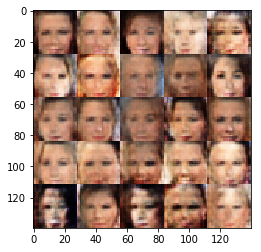

Epoch 1/1 Batch# 3110... Discriminator Loss: 0.9832... Generator Loss: 0.7274
Epoch 1/1 Batch# 3120... Discriminator Loss: 1.1316... Generator Loss: 0.5827
Epoch 1/1 Batch# 3130... Discriminator Loss: 0.9508... Generator Loss: 0.9639
Epoch 1/1 Batch# 3140... Discriminator Loss: 1.0162... Generator Loss: 0.7493
Epoch 1/1 Batch# 3150... Discriminator Loss: 1.0464... Generator Loss: 0.8557
Epoch 1/1 Batch# 3160... Discriminator Loss: 0.8839... Generator Loss: 0.9729
Epoch 1/1 Batch# 3170... Discriminator Loss: 0.6430... Generator Loss: 1.6107
Epoch 1/1 Batch# 3180... Discriminator Loss: 1.0832... Generator Loss: 1.1594
Epoch 1/1 Batch# 3190... Discriminator Loss: 1.4298... Generator Loss: 1.0513
Epoch 1/1 Batch# 3200... Discriminator Loss: 0.9422... Generator Loss: 0.8799


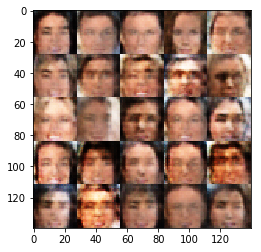

Epoch 1/1 Batch# 3210... Discriminator Loss: 0.8152... Generator Loss: 1.5240
Epoch 1/1 Batch# 3220... Discriminator Loss: 1.1691... Generator Loss: 0.6307
Epoch 1/1 Batch# 3230... Discriminator Loss: 0.8472... Generator Loss: 1.3018
Epoch 1/1 Batch# 3240... Discriminator Loss: 1.2226... Generator Loss: 1.0816
Epoch 1/1 Batch# 3250... Discriminator Loss: 1.4185... Generator Loss: 0.5525
Epoch 1/1 Batch# 3260... Discriminator Loss: 0.9164... Generator Loss: 0.5160
Epoch 1/1 Batch# 3270... Discriminator Loss: 1.0742... Generator Loss: 1.4862
Epoch 1/1 Batch# 3280... Discriminator Loss: 0.8569... Generator Loss: 1.3786
Epoch 1/1 Batch# 3290... Discriminator Loss: 0.9071... Generator Loss: 1.3393
Epoch 1/1 Batch# 3300... Discriminator Loss: 1.4865... Generator Loss: 0.3410


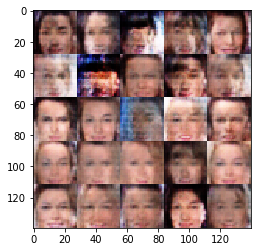

Epoch 1/1 Batch# 3310... Discriminator Loss: 0.8985... Generator Loss: 0.7757
Epoch 1/1 Batch# 3320... Discriminator Loss: 1.3188... Generator Loss: 0.6864
Epoch 1/1 Batch# 3330... Discriminator Loss: 0.6786... Generator Loss: 1.1726
Epoch 1/1 Batch# 3340... Discriminator Loss: 0.7812... Generator Loss: 1.2719
Epoch 1/1 Batch# 3350... Discriminator Loss: 0.8188... Generator Loss: 0.7381
Epoch 1/1 Batch# 3360... Discriminator Loss: 1.3683... Generator Loss: 0.8471
Epoch 1/1 Batch# 3370... Discriminator Loss: 1.1487... Generator Loss: 0.6739
Epoch 1/1 Batch# 3380... Discriminator Loss: 1.0815... Generator Loss: 0.6393
Epoch 1/1 Batch# 3390... Discriminator Loss: 0.6634... Generator Loss: 1.0732
Epoch 1/1 Batch# 3400... Discriminator Loss: 1.0335... Generator Loss: 1.3090


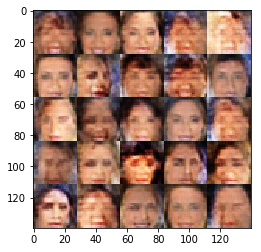

Epoch 1/1 Batch# 3410... Discriminator Loss: 0.8720... Generator Loss: 1.2421
Epoch 1/1 Batch# 3420... Discriminator Loss: 0.9394... Generator Loss: 0.7974
Epoch 1/1 Batch# 3430... Discriminator Loss: 0.7227... Generator Loss: 1.3632
Epoch 1/1 Batch# 3440... Discriminator Loss: 1.3840... Generator Loss: 0.5464
Epoch 1/1 Batch# 3450... Discriminator Loss: 0.9826... Generator Loss: 1.0171
Epoch 1/1 Batch# 3460... Discriminator Loss: 0.7639... Generator Loss: 0.4500
Epoch 1/1 Batch# 3470... Discriminator Loss: 0.5074... Generator Loss: 1.0638
Epoch 1/1 Batch# 3480... Discriminator Loss: 1.3133... Generator Loss: 0.4783
Epoch 1/1 Batch# 3490... Discriminator Loss: 0.4769... Generator Loss: 0.8528
Epoch 1/1 Batch# 3500... Discriminator Loss: 1.1191... Generator Loss: 0.9393


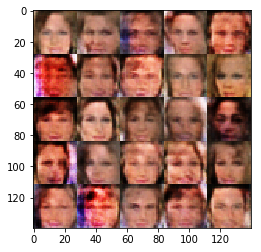

Epoch 1/1 Batch# 3510... Discriminator Loss: 0.6081... Generator Loss: 1.1755
Epoch 1/1 Batch# 3520... Discriminator Loss: 0.7678... Generator Loss: 1.2426
Epoch 1/1 Batch# 3530... Discriminator Loss: 0.8270... Generator Loss: 0.6956
Epoch 1/1 Batch# 3540... Discriminator Loss: 1.2641... Generator Loss: 0.8441
Epoch 1/1 Batch# 3550... Discriminator Loss: 0.8526... Generator Loss: 1.0357
Epoch 1/1 Batch# 3560... Discriminator Loss: 0.6343... Generator Loss: 1.0305
Epoch 1/1 Batch# 3570... Discriminator Loss: 1.2174... Generator Loss: 0.5050
Epoch 1/1 Batch# 3580... Discriminator Loss: 0.7071... Generator Loss: 1.2697
Epoch 1/1 Batch# 3590... Discriminator Loss: 1.1945... Generator Loss: 0.5893
Epoch 1/1 Batch# 3600... Discriminator Loss: 1.0368... Generator Loss: 0.7768


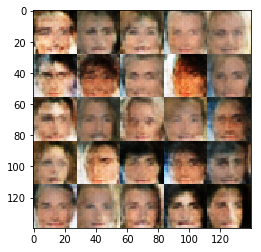

Epoch 1/1 Batch# 3610... Discriminator Loss: 1.0814... Generator Loss: 0.6169
Epoch 1/1 Batch# 3620... Discriminator Loss: 0.9509... Generator Loss: 1.0852
Epoch 1/1 Batch# 3630... Discriminator Loss: 0.6882... Generator Loss: 0.8372
Epoch 1/1 Batch# 3640... Discriminator Loss: 1.0430... Generator Loss: 0.9401
Epoch 1/1 Batch# 3650... Discriminator Loss: 0.8191... Generator Loss: 0.5578
Epoch 1/1 Batch# 3660... Discriminator Loss: 1.2339... Generator Loss: 0.8214
Epoch 1/1 Batch# 3670... Discriminator Loss: 1.1336... Generator Loss: 0.8534
Epoch 1/1 Batch# 3680... Discriminator Loss: 0.9082... Generator Loss: 1.0570
Epoch 1/1 Batch# 3690... Discriminator Loss: 0.8335... Generator Loss: 0.9829
Epoch 1/1 Batch# 3700... Discriminator Loss: 0.7915... Generator Loss: 1.0995


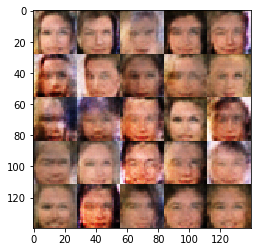

Epoch 1/1 Batch# 3710... Discriminator Loss: 0.6861... Generator Loss: 2.0119
Epoch 1/1 Batch# 3720... Discriminator Loss: 0.8719... Generator Loss: 1.1129
Epoch 1/1 Batch# 3730... Discriminator Loss: 1.0498... Generator Loss: 0.5906
Epoch 1/1 Batch# 3740... Discriminator Loss: 1.2364... Generator Loss: 0.5701
Epoch 1/1 Batch# 3750... Discriminator Loss: 0.9142... Generator Loss: 0.5988
Epoch 1/1 Batch# 3760... Discriminator Loss: 1.2179... Generator Loss: 0.8337
Epoch 1/1 Batch# 3770... Discriminator Loss: 1.3277... Generator Loss: 0.3455
Epoch 1/1 Batch# 3780... Discriminator Loss: 0.9830... Generator Loss: 1.2685
Epoch 1/1 Batch# 3790... Discriminator Loss: 0.9601... Generator Loss: 0.6613
Epoch 1/1 Batch# 3800... Discriminator Loss: 1.1190... Generator Loss: 0.6228


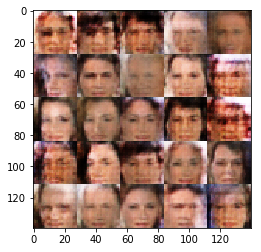

Epoch 1/1 Batch# 3810... Discriminator Loss: 0.7584... Generator Loss: 0.8312
Epoch 1/1 Batch# 3820... Discriminator Loss: 1.0114... Generator Loss: 1.0347
Epoch 1/1 Batch# 3830... Discriminator Loss: 1.0220... Generator Loss: 0.5293
Epoch 1/1 Batch# 3840... Discriminator Loss: 1.0966... Generator Loss: 1.2189
Epoch 1/1 Batch# 3850... Discriminator Loss: 1.4258... Generator Loss: 0.4543
Epoch 1/1 Batch# 3860... Discriminator Loss: 1.3887... Generator Loss: 0.3302
Epoch 1/1 Batch# 3870... Discriminator Loss: 0.8257... Generator Loss: 0.7129
Epoch 1/1 Batch# 3880... Discriminator Loss: 1.0927... Generator Loss: 0.6438
Epoch 1/1 Batch# 3890... Discriminator Loss: 0.8239... Generator Loss: 1.1055
Epoch 1/1 Batch# 3900... Discriminator Loss: 1.3412... Generator Loss: 0.5298


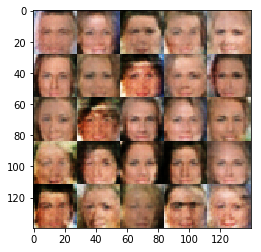

Epoch 1/1 Batch# 3910... Discriminator Loss: 1.3889... Generator Loss: 0.4382
Epoch 1/1 Batch# 3920... Discriminator Loss: 1.2366... Generator Loss: 1.3283
Epoch 1/1 Batch# 3930... Discriminator Loss: 0.8931... Generator Loss: 1.2975
Epoch 1/1 Batch# 3940... Discriminator Loss: 0.8946... Generator Loss: 0.8701
Epoch 1/1 Batch# 3950... Discriminator Loss: 1.1400... Generator Loss: 0.4366
Epoch 1/1 Batch# 3960... Discriminator Loss: 0.8562... Generator Loss: 0.9687
Epoch 1/1 Batch# 3970... Discriminator Loss: 0.9566... Generator Loss: 0.9750
Epoch 1/1 Batch# 3980... Discriminator Loss: 1.0124... Generator Loss: 1.1663
Epoch 1/1 Batch# 3990... Discriminator Loss: 0.6510... Generator Loss: 1.0535
Epoch 1/1 Batch# 4000... Discriminator Loss: 1.5377... Generator Loss: 0.5027


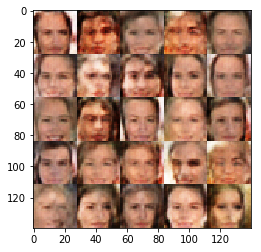

Epoch 1/1 Batch# 4010... Discriminator Loss: 1.1056... Generator Loss: 0.7005
Epoch 1/1 Batch# 4020... Discriminator Loss: 0.8747... Generator Loss: 1.3924
Epoch 1/1 Batch# 4030... Discriminator Loss: 0.8901... Generator Loss: 1.1143
Epoch 1/1 Batch# 4040... Discriminator Loss: 1.1758... Generator Loss: 0.4726
Epoch 1/1 Batch# 4050... Discriminator Loss: 1.1285... Generator Loss: 0.8470
Epoch 1/1 Batch# 4060... Discriminator Loss: 1.2517... Generator Loss: 0.5577
Epoch 1/1 Batch# 4070... Discriminator Loss: 1.1618... Generator Loss: 0.7843
Epoch 1/1 Batch# 4080... Discriminator Loss: 0.6969... Generator Loss: 1.3933
Epoch 1/1 Batch# 4090... Discriminator Loss: 1.1246... Generator Loss: 0.9592
Epoch 1/1 Batch# 4100... Discriminator Loss: 0.8273... Generator Loss: 1.2925


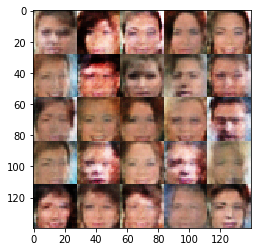

Epoch 1/1 Batch# 4110... Discriminator Loss: 0.4961... Generator Loss: 1.3721
Epoch 1/1 Batch# 4120... Discriminator Loss: 0.7728... Generator Loss: 0.7489
Epoch 1/1 Batch# 4130... Discriminator Loss: 0.8637... Generator Loss: 1.1723
Epoch 1/1 Batch# 4140... Discriminator Loss: 1.1727... Generator Loss: 0.9567
Epoch 1/1 Batch# 4150... Discriminator Loss: 1.4650... Generator Loss: 0.3893
Epoch 1/1 Batch# 4160... Discriminator Loss: 0.8187... Generator Loss: 1.4405
Epoch 1/1 Batch# 4170... Discriminator Loss: 0.7654... Generator Loss: 0.7742
Epoch 1/1 Batch# 4180... Discriminator Loss: 0.6960... Generator Loss: 1.1389
Epoch 1/1 Batch# 4190... Discriminator Loss: 0.7145... Generator Loss: 1.0357
Epoch 1/1 Batch# 4200... Discriminator Loss: 0.8535... Generator Loss: 1.0014


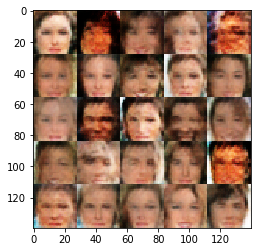

Epoch 1/1 Batch# 4210... Discriminator Loss: 0.6337... Generator Loss: 0.6683
Epoch 1/1 Batch# 4220... Discriminator Loss: 0.7724... Generator Loss: 0.9407
Epoch 1/1 Batch# 4230... Discriminator Loss: 0.7585... Generator Loss: 1.3946
Epoch 1/1 Batch# 4240... Discriminator Loss: 1.5370... Generator Loss: 0.6052
Epoch 1/1 Batch# 4250... Discriminator Loss: 0.7877... Generator Loss: 0.9606
Epoch 1/1 Batch# 4260... Discriminator Loss: 0.9909... Generator Loss: 0.6526
Epoch 1/1 Batch# 4270... Discriminator Loss: 0.9269... Generator Loss: 0.7769
Epoch 1/1 Batch# 4280... Discriminator Loss: 1.1369... Generator Loss: 0.5950
Epoch 1/1 Batch# 4290... Discriminator Loss: 0.6951... Generator Loss: 1.2804
Epoch 1/1 Batch# 4300... Discriminator Loss: 0.8107... Generator Loss: 1.1758


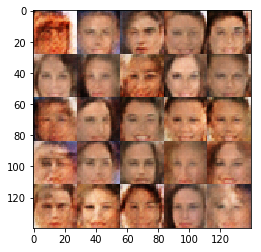

Epoch 1/1 Batch# 4310... Discriminator Loss: 1.5167... Generator Loss: 0.8521
Epoch 1/1 Batch# 4320... Discriminator Loss: 0.8587... Generator Loss: 1.4392
Epoch 1/1 Batch# 4330... Discriminator Loss: 1.0127... Generator Loss: 0.9078
Epoch 1/1 Batch# 4340... Discriminator Loss: 0.9347... Generator Loss: 0.6399
Epoch 1/1 Batch# 4350... Discriminator Loss: 0.7985... Generator Loss: 1.0487
Epoch 1/1 Batch# 4360... Discriminator Loss: 0.7573... Generator Loss: 1.8744
Epoch 1/1 Batch# 4370... Discriminator Loss: 1.1016... Generator Loss: 0.6224
Epoch 1/1 Batch# 4380... Discriminator Loss: 1.0318... Generator Loss: 0.5430
Epoch 1/1 Batch# 4390... Discriminator Loss: 1.1744... Generator Loss: 1.2504
Epoch 1/1 Batch# 4400... Discriminator Loss: 1.1787... Generator Loss: 1.0489


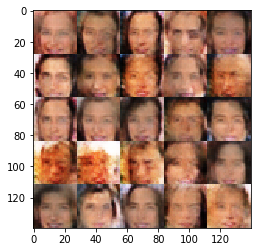

Epoch 1/1 Batch# 4410... Discriminator Loss: 1.2127... Generator Loss: 0.4553
Epoch 1/1 Batch# 4420... Discriminator Loss: 1.1346... Generator Loss: 0.7060
Epoch 1/1 Batch# 4430... Discriminator Loss: 1.6664... Generator Loss: 2.1548
Epoch 1/1 Batch# 4440... Discriminator Loss: 1.3559... Generator Loss: 1.2504
Epoch 1/1 Batch# 4450... Discriminator Loss: 0.4840... Generator Loss: 1.4133
Epoch 1/1 Batch# 4460... Discriminator Loss: 1.5150... Generator Loss: 1.1277
Epoch 1/1 Batch# 4470... Discriminator Loss: 0.5900... Generator Loss: 1.7813
Epoch 1/1 Batch# 4480... Discriminator Loss: 0.8399... Generator Loss: 1.0865
Epoch 1/1 Batch# 4490... Discriminator Loss: 1.2511... Generator Loss: 0.4690
Epoch 1/1 Batch# 4500... Discriminator Loss: 1.2283... Generator Loss: 1.0631


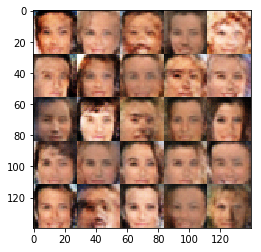

Epoch 1/1 Batch# 4510... Discriminator Loss: 0.8398... Generator Loss: 1.0195
Epoch 1/1 Batch# 4520... Discriminator Loss: 1.1092... Generator Loss: 1.3247
Epoch 1/1 Batch# 4530... Discriminator Loss: 1.2138... Generator Loss: 0.9917
Epoch 1/1 Batch# 4540... Discriminator Loss: 0.9210... Generator Loss: 1.0790
Epoch 1/1 Batch# 4550... Discriminator Loss: 1.5635... Generator Loss: 0.4719
Epoch 1/1 Batch# 4560... Discriminator Loss: 0.8660... Generator Loss: 0.5869
Epoch 1/1 Batch# 4570... Discriminator Loss: 0.8633... Generator Loss: 0.7939
Epoch 1/1 Batch# 4580... Discriminator Loss: 1.3386... Generator Loss: 0.3134
Epoch 1/1 Batch# 4590... Discriminator Loss: 0.9257... Generator Loss: 1.1828
Epoch 1/1 Batch# 4600... Discriminator Loss: 1.1902... Generator Loss: 1.4995


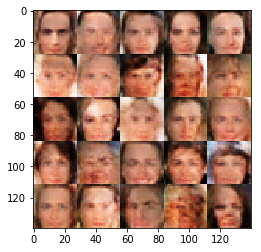

Epoch 1/1 Batch# 4610... Discriminator Loss: 1.5008... Generator Loss: 0.4889
Epoch 1/1 Batch# 4620... Discriminator Loss: 1.5183... Generator Loss: 0.4767
Epoch 1/1 Batch# 4630... Discriminator Loss: 1.1427... Generator Loss: 0.4953
Epoch 1/1 Batch# 4640... Discriminator Loss: 0.6232... Generator Loss: 1.5595
Epoch 1/1 Batch# 4650... Discriminator Loss: 1.8628... Generator Loss: 0.5910
Epoch 1/1 Batch# 4660... Discriminator Loss: 0.7984... Generator Loss: 0.6634
Epoch 1/1 Batch# 4670... Discriminator Loss: 0.6488... Generator Loss: 1.2467
Epoch 1/1 Batch# 4680... Discriminator Loss: 1.1662... Generator Loss: 0.6345
Epoch 1/1 Batch# 4690... Discriminator Loss: 1.1233... Generator Loss: 0.3641
Epoch 1/1 Batch# 4700... Discriminator Loss: 1.3091... Generator Loss: 0.5600


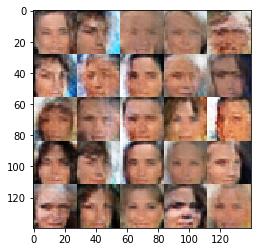

Epoch 1/1 Batch# 4710... Discriminator Loss: 0.8653... Generator Loss: 1.2711
Epoch 1/1 Batch# 4720... Discriminator Loss: 1.3599... Generator Loss: 0.5702
Epoch 1/1 Batch# 4730... Discriminator Loss: 1.5190... Generator Loss: 1.1546
Epoch 1/1 Batch# 4740... Discriminator Loss: 1.1550... Generator Loss: 1.0360
Epoch 1/1 Batch# 4750... Discriminator Loss: 0.7330... Generator Loss: 1.3924
Epoch 1/1 Batch# 4760... Discriminator Loss: 0.8294... Generator Loss: 1.0537
Epoch 1/1 Batch# 4770... Discriminator Loss: 1.6346... Generator Loss: 1.2421
Epoch 1/1 Batch# 4780... Discriminator Loss: 0.9345... Generator Loss: 0.6853
Epoch 1/1 Batch# 4790... Discriminator Loss: 0.9190... Generator Loss: 0.8882
Epoch 1/1 Batch# 4800... Discriminator Loss: 1.5722... Generator Loss: 0.6204


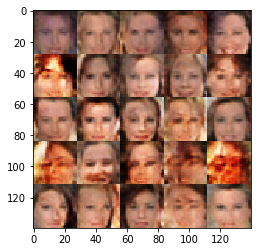

Epoch 1/1 Batch# 4810... Discriminator Loss: 0.6724... Generator Loss: 0.8033
Epoch 1/1 Batch# 4820... Discriminator Loss: 0.5970... Generator Loss: 1.1921
Epoch 1/1 Batch# 4830... Discriminator Loss: 0.7418... Generator Loss: 0.9204
Epoch 1/1 Batch# 4840... Discriminator Loss: 1.1238... Generator Loss: 0.7937
Epoch 1/1 Batch# 4850... Discriminator Loss: 1.2570... Generator Loss: 0.5790
Epoch 1/1 Batch# 4860... Discriminator Loss: 0.7238... Generator Loss: 0.4308
Epoch 1/1 Batch# 4870... Discriminator Loss: 1.2523... Generator Loss: 0.5707
Epoch 1/1 Batch# 4880... Discriminator Loss: 0.8470... Generator Loss: 1.0938
Epoch 1/1 Batch# 4890... Discriminator Loss: 1.0513... Generator Loss: 0.7785
Epoch 1/1 Batch# 4900... Discriminator Loss: 0.8602... Generator Loss: 0.9608


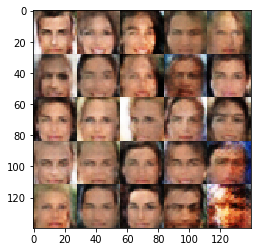

Epoch 1/1 Batch# 4910... Discriminator Loss: 0.9256... Generator Loss: 1.0445
Epoch 1/1 Batch# 4920... Discriminator Loss: 0.5170... Generator Loss: 1.1783
Epoch 1/1 Batch# 4930... Discriminator Loss: 0.7588... Generator Loss: 0.9598
Epoch 1/1 Batch# 4940... Discriminator Loss: 0.5650... Generator Loss: 0.6302
Epoch 1/1 Batch# 4950... Discriminator Loss: 1.2405... Generator Loss: 1.1187
Epoch 1/1 Batch# 4960... Discriminator Loss: 0.5991... Generator Loss: 0.9759
Epoch 1/1 Batch# 4970... Discriminator Loss: 0.7284... Generator Loss: 0.8089
Epoch 1/1 Batch# 4980... Discriminator Loss: 1.1123... Generator Loss: 0.8945
Epoch 1/1 Batch# 4990... Discriminator Loss: 1.5686... Generator Loss: 1.4430
Epoch 1/1 Batch# 5000... Discriminator Loss: 1.4345... Generator Loss: 0.4825


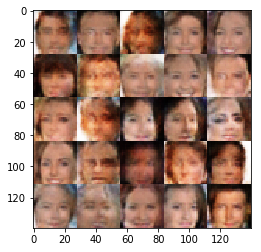

Epoch 1/1 Batch# 5010... Discriminator Loss: 1.2116... Generator Loss: 1.0878
Epoch 1/1 Batch# 5020... Discriminator Loss: 0.9066... Generator Loss: 0.6138
Epoch 1/1 Batch# 5030... Discriminator Loss: 1.0406... Generator Loss: 0.8651
Epoch 1/1 Batch# 5040... Discriminator Loss: 1.0529... Generator Loss: 0.5323
Epoch 1/1 Batch# 5050... Discriminator Loss: 0.9393... Generator Loss: 0.5939
Epoch 1/1 Batch# 5060... Discriminator Loss: 1.1196... Generator Loss: 1.1367
Epoch 1/1 Batch# 5070... Discriminator Loss: 0.9505... Generator Loss: 2.1386
Epoch 1/1 Batch# 5080... Discriminator Loss: 0.7500... Generator Loss: 1.8083
Epoch 1/1 Batch# 5090... Discriminator Loss: 1.3356... Generator Loss: 0.5012
Epoch 1/1 Batch# 5100... Discriminator Loss: 0.7378... Generator Loss: 1.3061


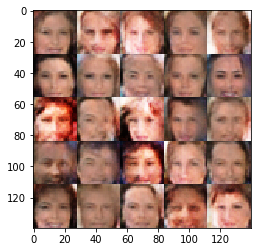

Epoch 1/1 Batch# 5110... Discriminator Loss: 1.5350... Generator Loss: 0.2350
Epoch 1/1 Batch# 5120... Discriminator Loss: 0.9916... Generator Loss: 0.8498
Epoch 1/1 Batch# 5130... Discriminator Loss: 0.8091... Generator Loss: 0.7775
Epoch 1/1 Batch# 5140... Discriminator Loss: 0.5628... Generator Loss: 1.7073
Epoch 1/1 Batch# 5150... Discriminator Loss: 0.6960... Generator Loss: 1.9250
Epoch 1/1 Batch# 5160... Discriminator Loss: 1.1040... Generator Loss: 0.3616
Epoch 1/1 Batch# 5170... Discriminator Loss: 0.9369... Generator Loss: 0.9147
Epoch 1/1 Batch# 5180... Discriminator Loss: 1.0598... Generator Loss: 0.6108
Epoch 1/1 Batch# 5190... Discriminator Loss: 0.9943... Generator Loss: 0.6369
Epoch 1/1 Batch# 5200... Discriminator Loss: 0.3790... Generator Loss: 1.6355


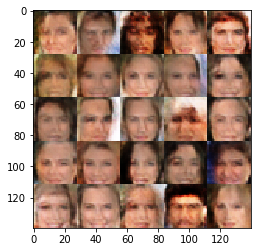

Epoch 1/1 Batch# 5210... Discriminator Loss: 1.1934... Generator Loss: 0.5278
Epoch 1/1 Batch# 5220... Discriminator Loss: 0.9041... Generator Loss: 0.7910
Epoch 1/1 Batch# 5230... Discriminator Loss: 0.9523... Generator Loss: 0.4179
Epoch 1/1 Batch# 5240... Discriminator Loss: 0.9651... Generator Loss: 1.3358
Epoch 1/1 Batch# 5250... Discriminator Loss: 1.3180... Generator Loss: 0.4522
Epoch 1/1 Batch# 5260... Discriminator Loss: 1.0254... Generator Loss: 1.6915
Epoch 1/1 Batch# 5270... Discriminator Loss: 1.2688... Generator Loss: 0.4238
Epoch 1/1 Batch# 5280... Discriminator Loss: 1.0643... Generator Loss: 0.8730
Epoch 1/1 Batch# 5290... Discriminator Loss: 0.6746... Generator Loss: 0.8736
Epoch 1/1 Batch# 5300... Discriminator Loss: 1.0563... Generator Loss: 1.0872


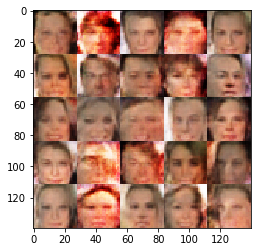

Epoch 1/1 Batch# 5310... Discriminator Loss: 0.7122... Generator Loss: 0.9547
Epoch 1/1 Batch# 5320... Discriminator Loss: 0.8825... Generator Loss: 0.9362
Epoch 1/1 Batch# 5330... Discriminator Loss: 0.8816... Generator Loss: 1.1747
Epoch 1/1 Batch# 5340... Discriminator Loss: 1.2892... Generator Loss: 0.4330
Epoch 1/1 Batch# 5350... Discriminator Loss: 0.8475... Generator Loss: 0.7792
Epoch 1/1 Batch# 5360... Discriminator Loss: 0.9799... Generator Loss: 1.0035
Epoch 1/1 Batch# 5370... Discriminator Loss: 0.8637... Generator Loss: 1.5462
Epoch 1/1 Batch# 5380... Discriminator Loss: 0.6970... Generator Loss: 0.9072
Epoch 1/1 Batch# 5390... Discriminator Loss: 0.7855... Generator Loss: 1.2111
Epoch 1/1 Batch# 5400... Discriminator Loss: 0.9970... Generator Loss: 1.1871


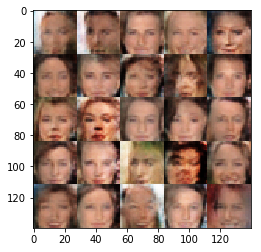

Epoch 1/1 Batch# 5410... Discriminator Loss: 1.3469... Generator Loss: 0.4798
Epoch 1/1 Batch# 5420... Discriminator Loss: 1.3661... Generator Loss: 0.5223
Epoch 1/1 Batch# 5430... Discriminator Loss: 0.5743... Generator Loss: 0.8662
Epoch 1/1 Batch# 5440... Discriminator Loss: 1.1402... Generator Loss: 0.5107
Epoch 1/1 Batch# 5450... Discriminator Loss: 1.1409... Generator Loss: 0.4885
Epoch 1/1 Batch# 5460... Discriminator Loss: 0.8545... Generator Loss: 0.6284
Epoch 1/1 Batch# 5470... Discriminator Loss: 1.0108... Generator Loss: 0.4913
Epoch 1/1 Batch# 5480... Discriminator Loss: 1.7259... Generator Loss: 1.6761
Epoch 1/1 Batch# 5490... Discriminator Loss: 1.0673... Generator Loss: 0.7159
Epoch 1/1 Batch# 5500... Discriminator Loss: 0.5289... Generator Loss: 0.9005


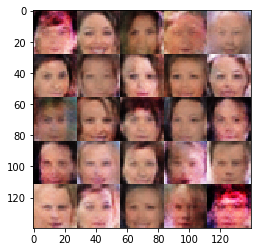

Epoch 1/1 Batch# 5510... Discriminator Loss: 0.3090... Generator Loss: 1.2965
Epoch 1/1 Batch# 5520... Discriminator Loss: 0.8133... Generator Loss: 1.0035
Epoch 1/1 Batch# 5530... Discriminator Loss: 1.0215... Generator Loss: 1.0233
Epoch 1/1 Batch# 5540... Discriminator Loss: 1.3030... Generator Loss: 1.4156
Epoch 1/1 Batch# 5550... Discriminator Loss: 1.0725... Generator Loss: 0.8762
Epoch 1/1 Batch# 5560... Discriminator Loss: 1.0989... Generator Loss: 0.5378
Epoch 1/1 Batch# 5570... Discriminator Loss: 0.8181... Generator Loss: 0.7223
Epoch 1/1 Batch# 5580... Discriminator Loss: 0.8733... Generator Loss: 0.6299
Epoch 1/1 Batch# 5590... Discriminator Loss: 0.8924... Generator Loss: 1.1255
Epoch 1/1 Batch# 5600... Discriminator Loss: 1.1387... Generator Loss: 0.6215


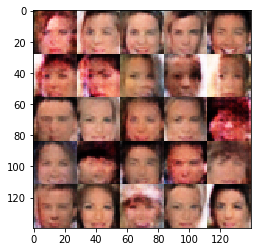

Epoch 1/1 Batch# 5610... Discriminator Loss: 0.7959... Generator Loss: 0.6534
Epoch 1/1 Batch# 5620... Discriminator Loss: 1.0973... Generator Loss: 0.5920
Epoch 1/1 Batch# 5630... Discriminator Loss: 1.0588... Generator Loss: 0.4244
Epoch 1/1 Batch# 5640... Discriminator Loss: 0.9427... Generator Loss: 0.8075
Epoch 1/1 Batch# 5650... Discriminator Loss: 0.6464... Generator Loss: 2.2422
Epoch 1/1 Batch# 5660... Discriminator Loss: 0.8103... Generator Loss: 0.7814
Epoch 1/1 Batch# 5670... Discriminator Loss: 1.1388... Generator Loss: 0.8075
Epoch 1/1 Batch# 5680... Discriminator Loss: 0.9815... Generator Loss: 0.6069
Epoch 1/1 Batch# 5690... Discriminator Loss: 1.0703... Generator Loss: 0.6492
Epoch 1/1 Batch# 5700... Discriminator Loss: 1.3176... Generator Loss: 1.3847


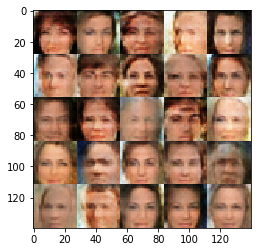

Epoch 1/1 Batch# 5710... Discriminator Loss: 1.2524... Generator Loss: 1.1998
Epoch 1/1 Batch# 5720... Discriminator Loss: 0.8561... Generator Loss: 0.6855
Epoch 1/1 Batch# 5730... Discriminator Loss: 0.6149... Generator Loss: 1.1235
Epoch 1/1 Batch# 5740... Discriminator Loss: 0.6084... Generator Loss: 0.7362
Epoch 1/1 Batch# 5750... Discriminator Loss: 0.7906... Generator Loss: 0.9388
Epoch 1/1 Batch# 5760... Discriminator Loss: 1.1251... Generator Loss: 0.6019
Epoch 1/1 Batch# 5770... Discriminator Loss: 0.8176... Generator Loss: 1.0517
Epoch 1/1 Batch# 5780... Discriminator Loss: 0.9746... Generator Loss: 0.8845
Epoch 1/1 Batch# 5790... Discriminator Loss: 0.6505... Generator Loss: 0.9270
Epoch 1/1 Batch# 5800... Discriminator Loss: 1.4883... Generator Loss: 0.6959


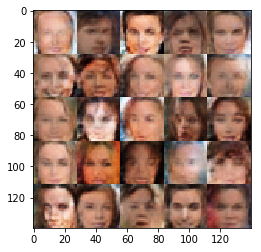

Epoch 1/1 Batch# 5810... Discriminator Loss: 0.9244... Generator Loss: 0.9381
Epoch 1/1 Batch# 5820... Discriminator Loss: 0.8296... Generator Loss: 0.5971
Epoch 1/1 Batch# 5830... Discriminator Loss: 0.8946... Generator Loss: 0.7502
Epoch 1/1 Batch# 5840... Discriminator Loss: 1.1949... Generator Loss: 0.7825
Epoch 1/1 Batch# 5850... Discriminator Loss: 1.1516... Generator Loss: 0.7968
Epoch 1/1 Batch# 5860... Discriminator Loss: 1.1374... Generator Loss: 1.1672
Epoch 1/1 Batch# 5870... Discriminator Loss: 0.8373... Generator Loss: 0.8718
Epoch 1/1 Batch# 5880... Discriminator Loss: 0.9758... Generator Loss: 0.6701
Epoch 1/1 Batch# 5890... Discriminator Loss: 0.8623... Generator Loss: 1.2042
Epoch 1/1 Batch# 5900... Discriminator Loss: 1.1429... Generator Loss: 0.5287


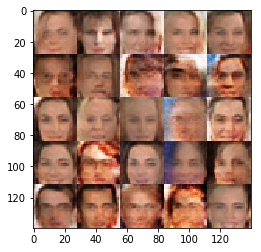

Epoch 1/1 Batch# 5910... Discriminator Loss: 1.0822... Generator Loss: 0.8744
Epoch 1/1 Batch# 5920... Discriminator Loss: 0.7609... Generator Loss: 1.2456
Epoch 1/1 Batch# 5930... Discriminator Loss: 0.8508... Generator Loss: 0.8089
Epoch 1/1 Batch# 5940... Discriminator Loss: 1.1260... Generator Loss: 0.6337
Epoch 1/1 Batch# 5950... Discriminator Loss: 1.4262... Generator Loss: 0.6497
Epoch 1/1 Batch# 5960... Discriminator Loss: 0.3481... Generator Loss: 1.4798
Epoch 1/1 Batch# 5970... Discriminator Loss: 0.6294... Generator Loss: 0.8628
Epoch 1/1 Batch# 5980... Discriminator Loss: 0.5666... Generator Loss: 0.9984
Epoch 1/1 Batch# 5990... Discriminator Loss: 1.0768... Generator Loss: 0.5286
Epoch 1/1 Batch# 6000... Discriminator Loss: 1.2900... Generator Loss: 0.7986


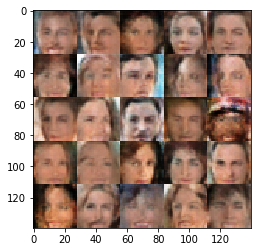

Epoch 1/1 Batch# 6010... Discriminator Loss: 0.7646... Generator Loss: 1.5363
Epoch 1/1 Batch# 6020... Discriminator Loss: 1.0460... Generator Loss: 1.4638
Epoch 1/1 Batch# 6030... Discriminator Loss: 0.7218... Generator Loss: 1.6581
Epoch 1/1 Batch# 6040... Discriminator Loss: 0.7230... Generator Loss: 0.6502
Epoch 1/1 Batch# 6050... Discriminator Loss: 1.1163... Generator Loss: 0.5121
Epoch 1/1 Batch# 6060... Discriminator Loss: 1.1023... Generator Loss: 0.8695
Epoch 1/1 Batch# 6070... Discriminator Loss: 0.9854... Generator Loss: 0.5650
Epoch 1/1 Batch# 6080... Discriminator Loss: 1.2897... Generator Loss: 0.6399
Epoch 1/1 Batch# 6090... Discriminator Loss: 0.9190... Generator Loss: 1.7350
Epoch 1/1 Batch# 6100... Discriminator Loss: 1.5491... Generator Loss: 0.6640


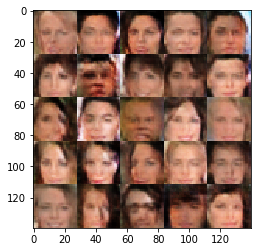

Epoch 1/1 Batch# 6110... Discriminator Loss: 0.7974... Generator Loss: 0.6949
Epoch 1/1 Batch# 6120... Discriminator Loss: 0.7724... Generator Loss: 0.6098
Epoch 1/1 Batch# 6130... Discriminator Loss: 0.8186... Generator Loss: 1.4530
Epoch 1/1 Batch# 6140... Discriminator Loss: 1.4865... Generator Loss: 0.7149
Epoch 1/1 Batch# 6150... Discriminator Loss: 1.0389... Generator Loss: 0.5958
Epoch 1/1 Batch# 6160... Discriminator Loss: 0.4444... Generator Loss: 1.2577
Epoch 1/1 Batch# 6170... Discriminator Loss: 1.7567... Generator Loss: 0.2910
Epoch 1/1 Batch# 6180... Discriminator Loss: 0.9350... Generator Loss: 0.5742
Epoch 1/1 Batch# 6190... Discriminator Loss: 1.0823... Generator Loss: 0.6378
Epoch 1/1 Batch# 6200... Discriminator Loss: 0.8516... Generator Loss: 1.0804


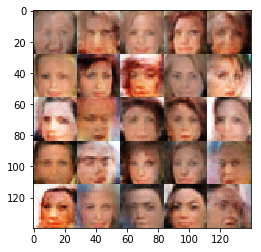

Epoch 1/1 Batch# 6210... Discriminator Loss: 1.2465... Generator Loss: 0.7450
Epoch 1/1 Batch# 6220... Discriminator Loss: 1.2961... Generator Loss: 0.5896
Epoch 1/1 Batch# 6230... Discriminator Loss: 0.8893... Generator Loss: 0.6340
Epoch 1/1 Batch# 6240... Discriminator Loss: 1.6770... Generator Loss: 0.6163
Epoch 1/1 Batch# 6250... Discriminator Loss: 0.9951... Generator Loss: 0.6029
Epoch 1/1 Batch# 6260... Discriminator Loss: 1.0634... Generator Loss: 0.6285
Epoch 1/1 Batch# 6270... Discriminator Loss: 0.9852... Generator Loss: 0.5914
Epoch 1/1 Batch# 6280... Discriminator Loss: 0.7804... Generator Loss: 1.0180
Epoch 1/1 Batch# 6290... Discriminator Loss: 1.0505... Generator Loss: 1.5931
Epoch 1/1 Batch# 6300... Discriminator Loss: 0.6469... Generator Loss: 1.4263


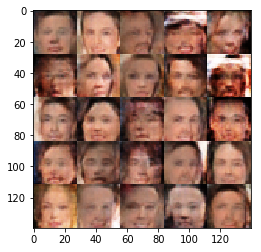

Epoch 1/1 Batch# 6310... Discriminator Loss: 0.9187... Generator Loss: 0.5097
Epoch 1/1 Batch# 6320... Discriminator Loss: 1.2843... Generator Loss: 0.4214
Epoch 1/1 Batch# 6330... Discriminator Loss: 0.9034... Generator Loss: 0.8046


In [46]:
batch_size = 32
z_dim = 200
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.